#  Модель предсказания оттока клиентов телекоммуникационной компании

   # Описание проекта: 
   Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.
    Описание услуг
    Оператор предоставляет два основных типа услуг:
    Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
    
    Также доступны такие услуги:
    Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    Выделенная линия технической поддержки (TechSupport);
    Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
    Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

    Описание данных
    Данные состоят из нескольких файлов, полученных из разных источников:
    — информация о договоре;
    — персональные данные клиента;
    — информация об интернет-услугах;
    — информация об услугах телефонии.
    
    Признаки    
    customerID — идентификатор абонента;
    BeginDate — дата начала действия договора;
    EndDate — дата окончания действия договора;
    Type — тип оплаты: раз в год-два или ежемесячно;
    PaperlessBilling — электронный расчётный лист;
    PaymentMethod — тип платежа;
    MonthlyCharges — расходы за месяц;
    TotalCharges — общие расходы абонента.   
    customerID — идентификатор пользователя;
    gender — пол;
    SeniorCitizen — является ли абонент пенсионером;
    Partner — есть ли у абонента супруг или супруга;
    Dependents — есть ли у абонента дети;
    customerID — идентификатор пользователя;
    InternetService — тип подключения;
    OnlineSecurity — блокировка опасных сайтов;
    OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    DeviceProtection — антивирус;
    TechSupport — выделенная линия технической поддержки;
    StreamingTV — стриминговое телевидение;
    StreamingMovies — каталог фильмов;
    customerID — идентификатор пользователя;
    MultipleLines — подключение телефона к нескольким линиям одновременно.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install phik -q
!pip install lightgbm -q

In [5]:
!pip install -U scikit-learn -q

In [6]:
!pip install --upgrade pandas

In [7]:
import os
import phik


import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

# для работы со временем
from time import time

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# метрика
from sklearn.metrics import (roc_auc_score,
                             accuracy_score,
                             roc_curve, 
                             confusion_matrix)

# CountVectorizer() Чтобы преобразовать корпус текстов в мешок слов
# TfidfVectorizer счётчик величин TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import( train_test_split,
                                    GridSearchCV, RandomizedSearchCV,
                                    StratifiedKFold)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler)
from sklearn.impute import SimpleImputer


from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier, Pool
# import lightgbm 
from lightgbm import LGBMClassifier

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

In [8]:
import sys
print(sys.executable)

C:\Users\User\anaconda3\python.exe


In [9]:
# создание констант для моделей
import random
RANDOM_STATE = 12082024

TEST_SIZE = 0.25
random.seed(RANDOM_STATE)

## Шаг 1. Загрузка данных
Загрузка данных и их первичный осмотр.

In [11]:
def load_data(paths):
    """
    Читает CSV-файл по указанному пути.

    paths: Список путей к файлам.
    return: DataFrame, если файл найден и прочитан, иначе None.
    """
    for path in paths:
        if os.path.exists(path):
            try:
                return pd.read_csv(path)
                print(f"Файл загружен из пути' {path}': {e}")
            
            except Exception as e:
                print(f"Ошибка при чтении файла '{path}': {e}")
                continue
    print("Файл не найден ни по одному из путей.")
    return None

In [12]:
# Загрузка датафрейма contract_new
paths = [
    '/Users/User/Documents/00_ЯП_шпаргалки/16_Выпускной_проект/datasets/contract_new.csv',
    '/datasets/contract_new.csv'
]

contract_new = load_data(paths)

In [13]:
contract_new.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [14]:
# Загрузка датафрейма contract_new
paths = [
    '/Users/User/Documents/00_ЯП_шпаргалки/16_Выпускной_проект/datasets/personal_new.csv',
    '/datasets/personal_new.csv'
]

personal_new = load_data(paths)

In [15]:
personal_new.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [16]:
# Загрузка датафрейма contract_new
paths = [
    '/Users/User/Documents/00_ЯП_шпаргалки/16_Выпускной_проект/datasets/internet_new.csv',
    '/datasets/internet_new.csv'
]

internet_new = load_data(paths)

In [17]:
internet_new.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [18]:
# Загрузка датафрейма contract_new
paths = [
    '/Users/User/Documents/00_ЯП_шпаргалки/16_Выпускной_проект/datasets/phone_new.csv',
    '/datasets/phone_new.csv'
]

phone_new = load_data(paths)

In [19]:
phone_new.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Вывод по разделу
- Все исходные данные загружены
- Названия столбцов не соответствуют snake case, заменять не будем но обратим внимание заказчика

## Шаг 2. Исследовательский анализ и предобработка данных
 исследовательский анализ каждого датафрейма и при необходимости выполните предобработку. Сделайте выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

In [22]:
def get_data_info(data):
    display(data.sample(5))
    display(data.describe(include='all'))
    display('Пропуски:', data.isna().sum())
    data.info()

In [23]:
def plot_box_hist(data):
    '''
    выбирает столбцы с числовыми значениями и строит гистограммы по ним
    '''
    #выбор числовых столбцов
    num_cols = data.select_dtypes(include=['number']).columns
    #размер
    num_plot = len(num_cols)
    plt.figure(figsize = (15,5*num_plot))
  
    for i, col in enumerate(num_cols):
        plt.subplot(num_plot, 2, 2*i+1)
        data[col].hist(bins = 50)
        plt.title(f'Гистограмма {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        
        plt.subplot(num_plot, 2, 2*i + 2)
        data.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
        
#         plt.subplot(num_plot, 2, 2*i + 2)
#         data.boxplot(vert = False, column=col)
#         plt.title(f'Диаграмма размаха {col}')
        
        
    plt.tight_layout()
    plt.show()

In [24]:
def data_unique(data):
    '''
    выводит количество уникальных значений для строковых данных в столбцах
    '''
    for column in data.columns:
        if data[column].dtype == 'object':
            print('Уникальных значений', column, '=', data[column].nunique())
            print('Значения:', data[column].unique())
            print()

In [25]:
def val_count(data, list):
    '''
    выводит количество значений в столбцах
    '''
    for column in list:
        print('Количество значений', data[column].value_counts())
        print()

In [26]:
def data_duplicates(data):
    '''
    выводит количество уникальных значений для строковых данных в столбцах
    '''
    print('повторяющихся строк:', data.duplicated().sum(), 'из', len(data))
    duplicates = data[data.duplicated ()]
    display(duplicates)
#     print(duplicates)

### информация о договоре (contract_new)

In [28]:
get_data_info(contract_new)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4118,4826-TZEVA,2016-10-01,No,Month-to-month,No,Credit card (automatic),74.8,3261.28
4848,5380-AFSSK,2019-06-01,No,Month-to-month,Yes,Mailed check,93.9,803.78
2624,0820-FNRNX,2018-09-01,No,Month-to-month,Yes,Mailed check,66.7,1167.92
6072,3387-PLKUI,2019-01-01,No,Month-to-month,No,Mailed check,18.8,249.29
5228,3589-PPVKW,2019-05-01,No,Month-to-month,Yes,Mailed check,44.4,399.6


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


'Пропуски:'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


признак TotalCharges имеет неверный тип данных исходя из описания, выясним почему это произошло.

In [30]:
contract_new.TotalCharges.value_counts()

TotalCharges
           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: count, Length: 6658, dtype: int64

In [31]:
contract_new.sort_values(by='TotalCharges').head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,


В TotalCharges 11 пропусков, это все клиенты от 2020-02-01 с оплатой в 1 или 2 года. Проверим последние значение признака EndDate чтобы понять могла ли у них на момент выгрузки пройти оплата

In [33]:
contract_new.loc[contract_new['EndDate'] != 'No'].sort_values(by='EndDate', ascending = False).head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5439,5959-BELXA,2017-05-01,2020-01-01,Month-to-month,Yes,Credit card (automatic),96.15,3322.94
4268,5198-HQAEN,2017-03-01,2020-01-01,One year,Yes,Electronic check,89.70,3202.29
6584,6340-DACFT,2015-12-01,2020-01-01,Two year,No,Credit card (automatic),20.55,1006.95


На момент выгрузки последняя дата в EndDate 2020-01-01, соответственно клиенты с BeginDate 2020-02-01 являются новыми и полная оплата еще не произведена и TotalCharges для них можно заполнить 0

In [35]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [36]:
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float64')
contract_new.info()
contract_new.sort_values(by='TotalCharges').head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.00
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.00
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.00
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.00
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0.00
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,0.00
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.00
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00


Замена пропусков в TotalCharges на 0 проведена

In [38]:
get_data_info(contract_new)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
802,8859-AXJZP,2016-11-01,No,Two year,Yes,Mailed check,23.80,965.33
2940,6313-GIDIT,2015-06-01,2018-11-01,Month-to-month,Yes,Electronic check,54.45,2232.45
5521,3863-QSTYI,2015-03-01,No,Month-to-month,Yes,Electronic check,64.65,3814.35
6713,4989-LIXVT,2014-06-01,2015-08-01,Month-to-month,Yes,Electronic check,95.90,1342.60
5751,0932-YIXYU,2016-03-01,No,Two year,No,Credit card (automatic),20.25,980.30


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000
unique,7043,77,67,3,2,4,NaN,NaN
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,NaN
freq,1,366,5942,3875,4171,2365,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1343.350000
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3236.690000


'Пропуски:'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


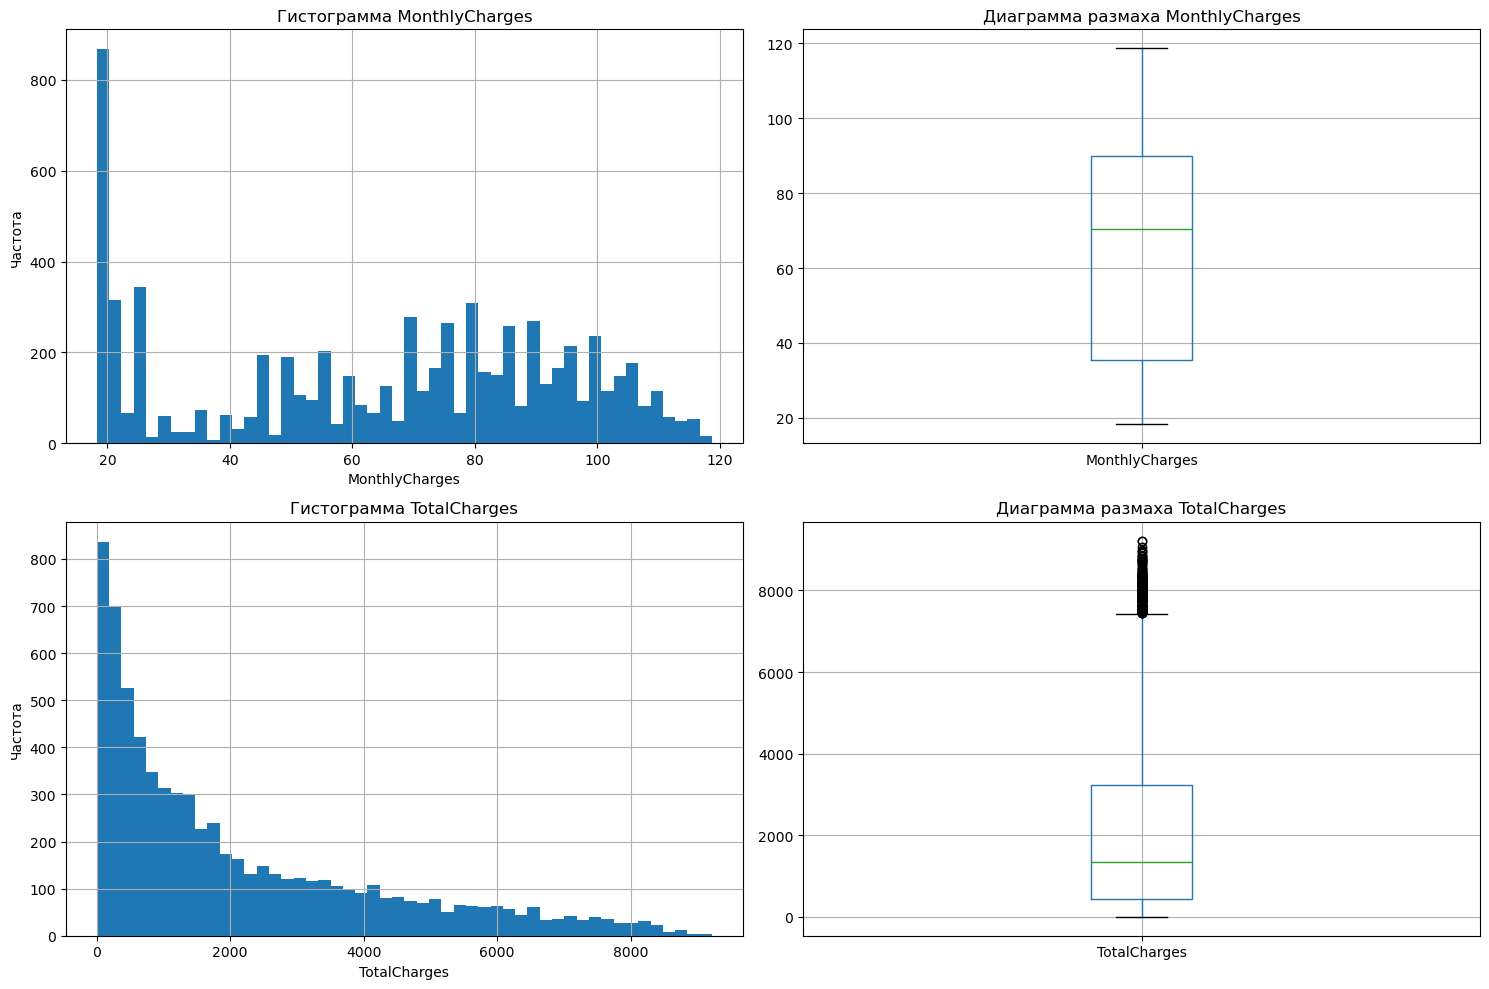

In [39]:
plot_box_hist(contract_new)

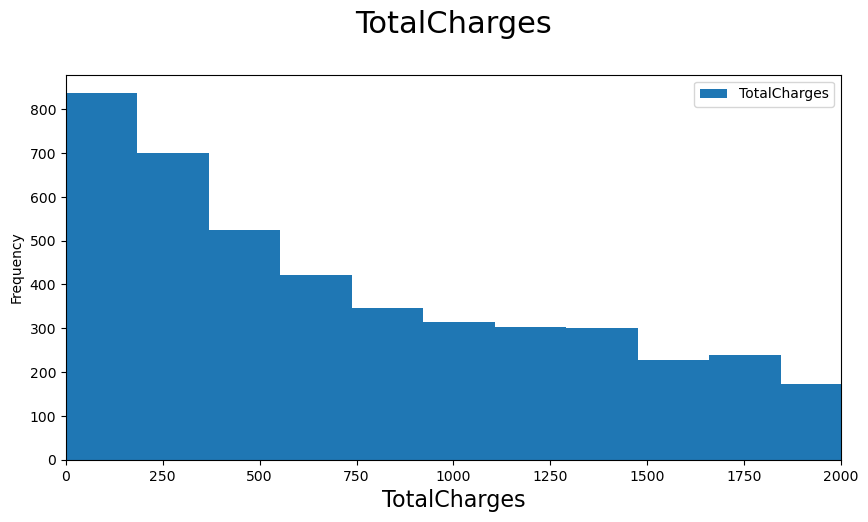

In [40]:
(contract_new.plot(y = 'TotalCharges', kind='hist', bins = 50, figsize = (10, 5))
 .set_title('TotalCharges' + "\n", fontsize = 22, color = 'black')
)
plt.xlim(0, 2000)
plt.xlabel('TotalCharges', fontsize = 16);

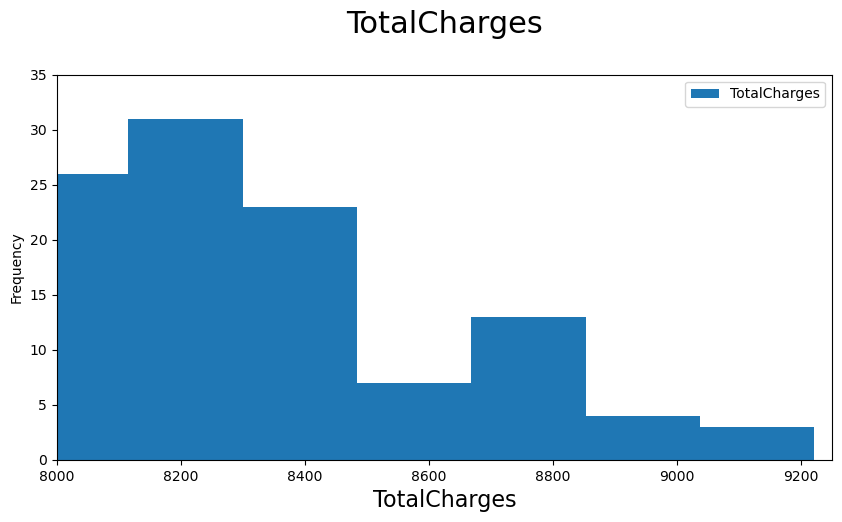

In [41]:
(contract_new.plot(y = 'TotalCharges', kind='hist', bins = 50, figsize = (10, 5))
 .set_title('TotalCharges' + "\n", fontsize = 22, color = 'black')
)
plt.xlim(8000, 9250)
plt.ylim(0, 35)
plt.xlabel('TotalCharges', fontsize = 16);

По гистограммам для признаков по тратам клиентов видно что большинство клиентов тратит в месяц до 20 у.е.(валюта расчетов не известна) на оплату услуг связи. 
Ьак-же по гистограмме месячных трат наблюдается множество пиков, разделим условно клиентов компании на несколько категорий по диапазонам затрат

### MonthlyChargesCategory

In [44]:
data_unique(contract_new)

Уникальных значений customerID = 7043
Значения: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Уникальных значений BeginDate = 77
Значения: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2

In [45]:
contract_new.sort_values(by='EndDate', ascending=False).head(3)
# contract_new.sort_values(by='EndDate').head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
4482,6711-FLDFB,2019-04-01,No,Month-to-month,Yes,Electronic check,74.90,749.00
4494,0225-ZORZP,2019-11-01,No,Month-to-month,No,Electronic check,84.30,263.02


    Т.к. в данных содержится 2 столбца с датами (начало и окончания действия договора) создадим на их основе целевой признак (активность клиента) который будет предсказываться моделью.Т.к. в столбце с датой окончания содержится значение No будем считавть что на момент выгрузки данных договор был действующим. 
    Также на основе этих столбцов созддадим признак с продолжительностью действия договора (пусть модель разбирается какая длительность может быть показателем к расторжению оговора и есть ли такая зависимость). Для расчета продолжительности потребуется заменить No в признаке EndDate на дату выгрузки датафрейма после создания целевого признака.

In [47]:
# Создание признака оттока "active" (1 - отток, 0 - активность)

contract_new['active'] = 1

contract_new.loc[contract_new['EndDate'] == 'No', 'active'] = 0


In [48]:
# Замена значения 'No' на '2020-02-01'
contract_new['EndDate'] = contract_new['EndDate'].replace('No', '2020-02-01')

In [49]:
# приведем столбцы с датами к формату datetime
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'], format='%Y-%m-%d')
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'], format='%Y-%m-%d')

In [50]:
# Создание признака "duration_contract"
contract_new['duration'] = (contract_new['EndDate'] - contract_new['BeginDate']).dt.components.days

In [51]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   active            7043 non-null   int64         
 9   duration          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


In [52]:
val_list = ('PaperlessBilling' , 'PaymentMethod', 'active')
val_count(contract_new, val_list)

Количество значений PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

Количество значений PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

Количество значений active
0    5942
1    1101
Name: count, dtype: int64



In [53]:
def plot_pie(df, column):
    ''' 
    Строит круговую диаграмму для выбранного категориального столбца в DataFrame.

    '''
    (df.groupby(column)[column].count()
     .plot(kind='pie', y =column, autopct='%1.2f%%', figsize = (6, 6))
     .set_title('Распределение значений в' + "\n"+ column + "\n", fontsize = 12, color = 'black')
    );

In [54]:
def create_pie_chart_matrix(df, columns, ncols, nrows, size):
    """Создает матрицу изображений круговых диаграмм для столбцов датафрейма."""
    fig = plt.figure(figsize=size)
    gs = gridspec.GridSpec(nrows, ncols)
    for i, col in enumerate(columns):
        ax = fig.add_subplot(gs[i])
        df[col].value_counts().plot.pie(autopct='%0.0f%%', ax=ax)
        ax.set_title(col)
        ax.axis('equal')  # Круговая диаграмма должна быть круглой
        
    return fig

In [55]:
#функция для получения из df списка с именами категориальных и числовых столбцов
def split_col(df):    
    return list(df.dtypes[df.dtypes=='object'].index), list(df.dtypes[df.dtypes!='object'].index)

In [56]:
val_list, num_col = split_col(contract_new.drop('customerID', axis=1))

In [57]:
val_list

['Type', 'PaperlessBilling', 'PaymentMethod']

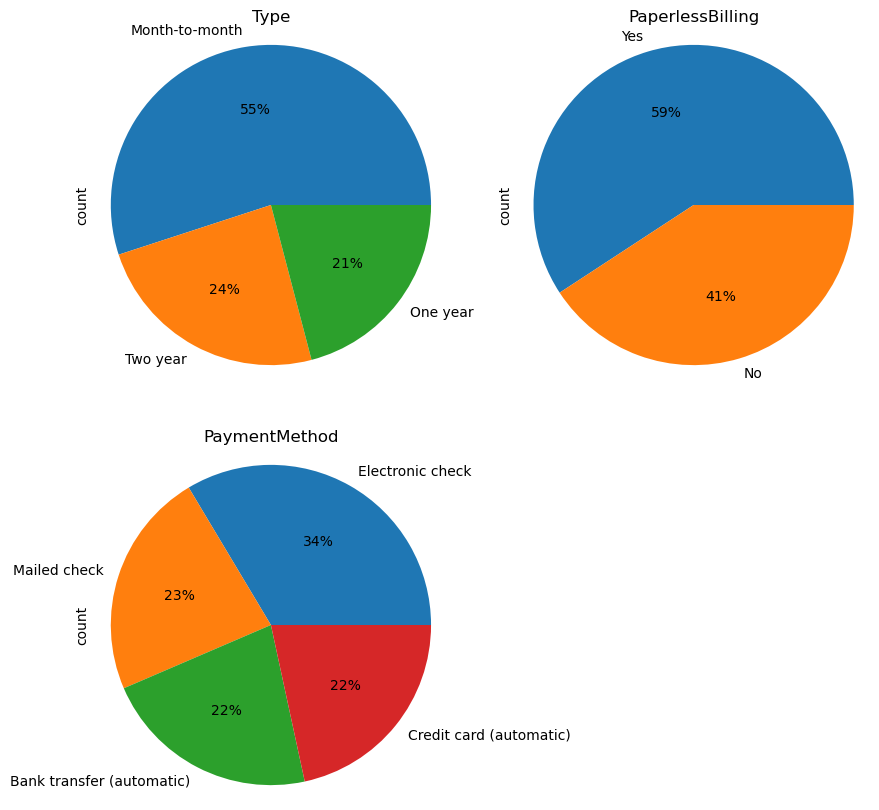

In [58]:
fig = create_pie_chart_matrix(contract_new, val_list, 2, 2, (10,10))

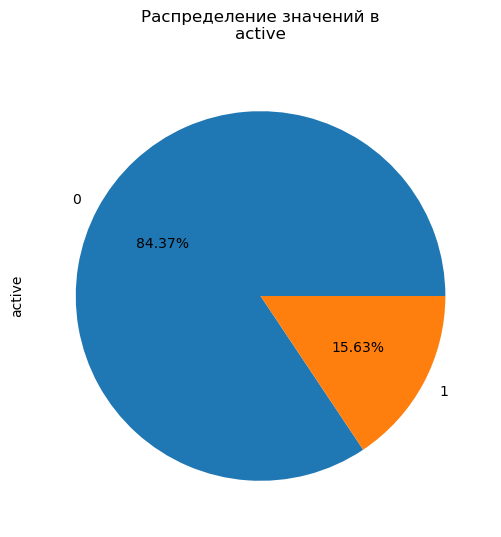

In [59]:
plot_pie(contract_new, 'active')

Более половины пользователей выбирают ежемесячную оплату и электронный расчетный лист. По методы оплаты 34% выбирают электронный чек, остальные вилы оплаты разделены примерно равномерно.В целевой переменной наблюдается дисбаланс классов, учтем это и при разделении выборок используем стратификацию

In [61]:
data_duplicates(contract_new)

повторяющихся строк: 0 из 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active,duration


In [62]:
# проверка на дубликаты по id
contract_new.customerID.duplicated().sum()

0

#### Вывод
- Таблица содержит 7043 записей. На первый взгляд данные не содержат пропусков, но признак BeginDate содержит не только даты но и текстовые значения которые требуется заменить. Т.к. мы знаем дату выгрузки данных будем использовать ее для замены. <b>Исправлено</b>
- Признак TotalCharges определился как object, хотя по описанию данных должен быть float. <b>Исправлено</b>
- На гистограме признака MonthlyCharges видно множество шипов. <b>На его основе создан новый категориальный признак по значению месячных затрат.</b>
- Признаки BeginDate и EndDate переведены в формат date <b>На их основе создан новый категориальный признак по продолжительности договора и целевой признак с активностью клиентов.</b>
- Признаки Type, PaymentMethod и PaperlessBilling будем кодировать One Hot Encoder для линейных моделей
- Признак PaymentMethod будем кодировать OrdinalEncoder для нелинейных моделей



### данные клиента (personal_new)

In [65]:
get_data_info(personal_new)

,customerID,gender,SeniorCitizen,Partner,Dependents
1728,8345-MVDYC,Female,0,No,No
2086,2955-BJZHG,Male,0,Yes,Yes
2903,0953-LGOVU,Male,0,Yes,Yes
4244,9975-GPKZU,Male,0,Yes,Yes
3713,6961-VCPMC,Male,1,Yes,No


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


'Пропуски:'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [66]:
val_list = personal_new.drop('customerID', axis=1).columns.tolist()

In [67]:
data_unique(personal_new[val_list])

Уникальных значений gender = 2
Значения: ['Female' 'Male']

Уникальных значений Partner = 2
Значения: ['Yes' 'No']

Уникальных значений Dependents = 2
Значения: ['No' 'Yes']



In [68]:
val_count(personal_new, val_list)

Количество значений gender
Male      3555
Female    3488
Name: count, dtype: int64

Количество значений SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

Количество значений Partner
No     3641
Yes    3402
Name: count, dtype: int64

Количество значений Dependents
No     4933
Yes    2110
Name: count, dtype: int64



In [69]:
# переведем признак SeniorCitizen в более понятный вид
personal_new['SeniorCitizen']= personal_new['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')

In [70]:
data_unique(personal_new[val_list])

Уникальных значений gender = 2
Значения: ['Female' 'Male']

Уникальных значений SeniorCitizen = 2
Значения: ['No' 'Yes']

Уникальных значений Partner = 2
Значения: ['Yes' 'No']

Уникальных значений Dependents = 2
Значения: ['No' 'Yes']



In [71]:
# val_list = personal_new.drop('customerID', axis=1).columns.tolist()
val_count(personal_new, val_list)

Количество значений gender
Male      3555
Female    3488
Name: count, dtype: int64

Количество значений SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

Количество значений Partner
No     3641
Yes    3402
Name: count, dtype: int64

Количество значений Dependents
No     4933
Yes    2110
Name: count, dtype: int64



In [72]:
data_duplicates(personal_new)

повторяющихся строк: 0 из 7043


,customerID,gender,SeniorCitizen,Partner,Dependents


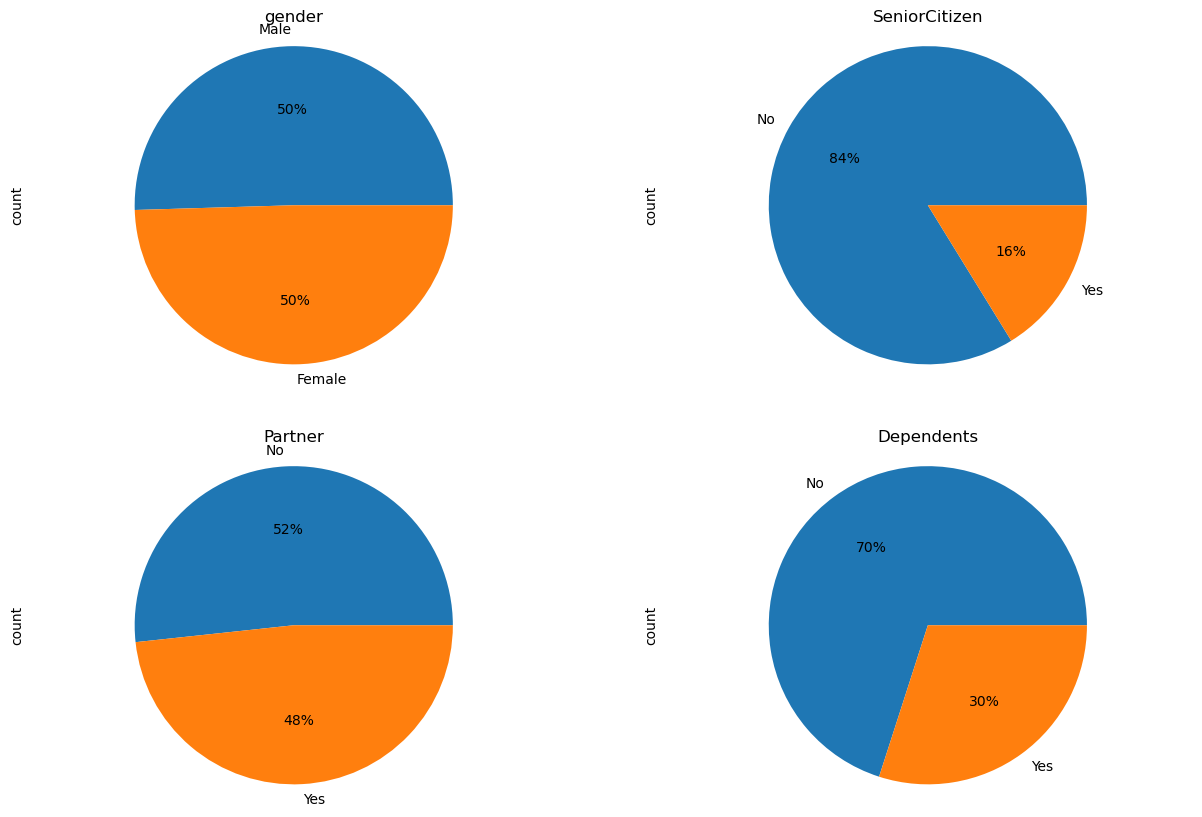

In [73]:
fig = create_pie_chart_matrix(personal_new, val_list, 2, 2, (15,10))

Значения признака gender разделены поровну, 52 % пользователей люди не состоящие в отношениях. 16% пользователей являются пенсионерами. У 30% есть дети.

In [75]:
personal_new.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
1190,6807-SIWJI,Male,No,No,No
5196,0786-IVLAW,Female,Yes,No,No
858,3224-DFQNQ,Female,No,Yes,No
5121,4903-CNOZC,Male,No,No,No
1124,8791-GFXLZ,Male,No,No,No


#### Вывод
- Таблица содержит 7043 записей. 
- Типы данных для признаков определены верно
- Признак SeniorCitizen переведен в категориальный
- Признаки из таблицы будем кодировать One Hot Encoder

### информация об интернет-услугах (internet_new)

In [78]:
get_data_info(internet_new)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2337,4674-HGNUA,DSL,Yes,Yes,Yes,Yes,Yes,Yes
3722,7402-PWYJJ,Fiber optic,No,No,No,Yes,No,Yes
3201,5640-CAXOA,DSL,No,No,No,Yes,No,Yes
2825,4488-KQFDT,Fiber optic,No,Yes,Yes,No,Yes,Yes
1223,0330-IVZHA,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Пропуски:'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [79]:
val_list = internet_new.drop('customerID', axis=1).columns.tolist()

In [80]:
data_unique(internet_new[val_list])

Уникальных значений InternetService = 2
Значения: ['DSL' 'Fiber optic']

Уникальных значений OnlineSecurity = 2
Значения: ['No' 'Yes']

Уникальных значений OnlineBackup = 2
Значения: ['Yes' 'No']

Уникальных значений DeviceProtection = 2
Значения: ['No' 'Yes']

Уникальных значений TechSupport = 2
Значения: ['No' 'Yes']

Уникальных значений StreamingTV = 2
Значения: ['No' 'Yes']

Уникальных значений StreamingMovies = 2
Значения: ['No' 'Yes']



In [81]:
# val_list = internet_new.drop('customerID', axis=1).columns.tolist()
val_count(internet_new, val_list)

Количество значений InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Количество значений OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

Количество значений OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

Количество значений DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

Количество значений TechSupport
No     3473
Yes    2044
Name: count, dtype: int64

Количество значений StreamingTV
No     2810
Yes    2707
Name: count, dtype: int64

Количество значений StreamingMovies
No     2785
Yes    2732
Name: count, dtype: int64



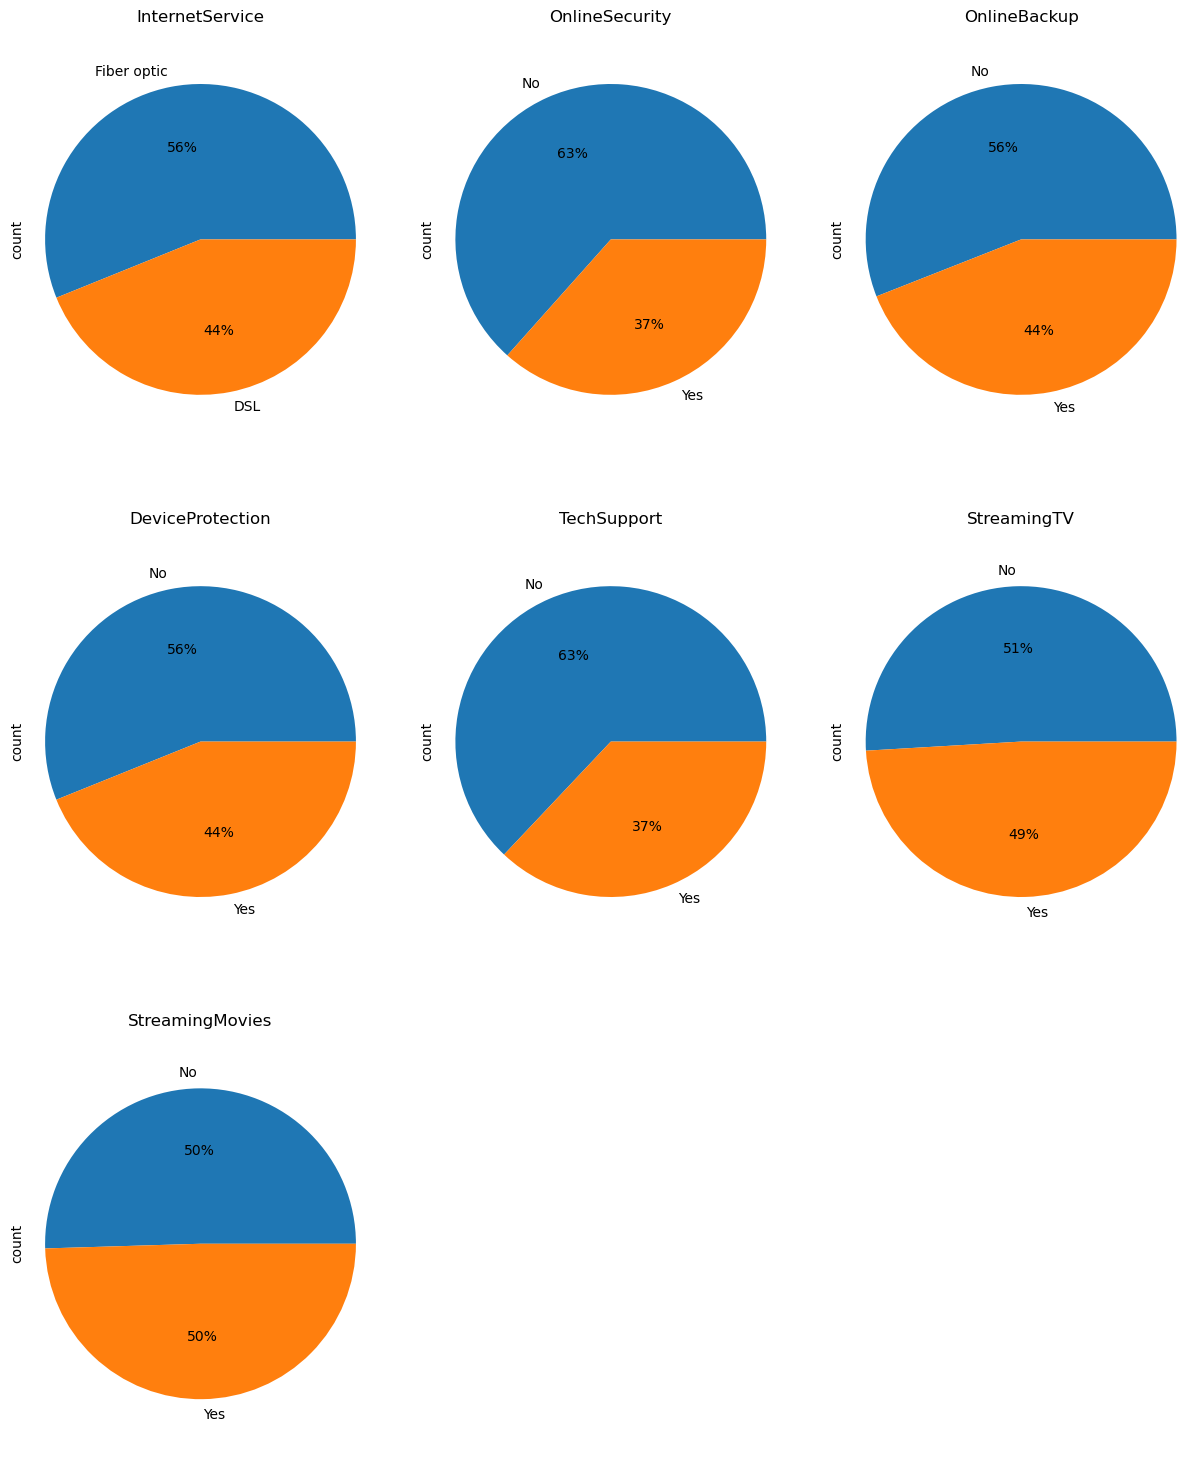

In [82]:
fig = create_pie_chart_matrix(internet_new, val_list, 3, 4, (15,25))


In [83]:
data_duplicates(internet_new)

повторяющихся строк: 0 из 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


#### Вывод
- Таблица содержит 5517 записей, что меньше чем в предыдущих таблицах. 
- Типы данных для признаков определены верно
- Таблица не содержит пропусков и дубликатов
- Все признаки будем кодировать One Hot Encoder
- Признак StreamingMovies разделен 50 на 50,в оатальных признака по услугам пользователи чаще ими пользкются чем отказываются

### информация об услугах телефонии (phone_new)

In [86]:
get_data_info(phone_new)

,customerID,MultipleLines
421,1304-BCCFO,No
3688,1915-IOFGU,No
3273,6185-TASNN,No
2795,4504-YOULA,Yes
5089,4818-DRBQT,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


'Пропуски:'

customerID       0
MultipleLines    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [87]:
val_list = phone_new.drop('customerID', axis=1).columns.tolist()

In [88]:
data_unique(phone_new[val_list])

Уникальных значений MultipleLines = 2
Значения: ['No' 'Yes']



In [89]:
# val_list = phone_new.drop('customerID', axis=1).columns.tolist()
val_count(phone_new, val_list)

Количество значений MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64



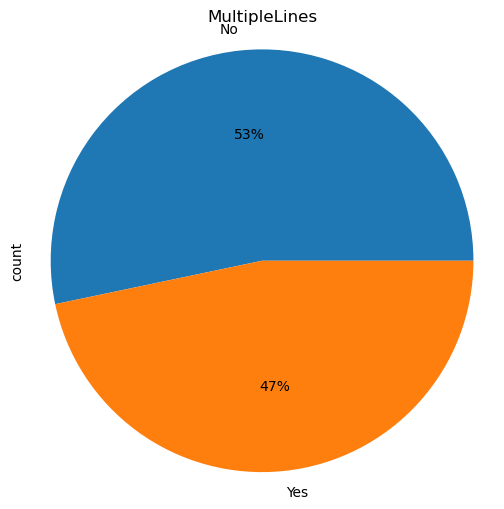

In [90]:
fig = create_pie_chart_matrix(phone_new, val_list,1, 1, (6,6))

In [91]:
data_duplicates(phone_new)

повторяющихся строк: 0 из 6361


,customerID,MultipleLines


#### Вывод
- Таблица содержит 6361 записей, что меньше чем в предыдущих таблицах. 
- Таблица не содержит пропусков и дубликатов
- В таблице содержится всего 1 признак, его тип определен правильно, будем кодировать One Hot Encoder
- 47% имеют несколько подключенных телефонных линий, возможно это корпоративные клиенты

### Вывод по разделу
- Были загружены 4 датафрейма с данными
- Исходные данные не содержат явных дубликатов
- Обнаруженные пропуски заменены медианой.
- Есть признаки с неправильно определенным типом данных. <b>Исправлено</b>
- После предобработки и объединения датафреймов в 1 возможно появление дубликатов и пропусков которые потребуют заполнения


## Шаг 3. Объединение данных
Объедините выбранные вами признаки в один датафрейм по ключу.


In [95]:
# объединим таблицы по признаку customerID и переведем его в индекс
total_data= personal_new.merge(contract_new, on='customerID', how='left')
total_data = total_data.merge(internet_new, on='customerID', how='left')
total_data = total_data.merge(phone_new, on='customerID', how='left').set_index('customerID')


In [96]:
# Удаление признкаов "BeginDate" и "EndDate", т.к. от даты заключения/расторжения
# не зависит останется или уйдет клиент и может снизить качество модели.
total_data = total_data.drop(['BeginDate', 'EndDate'], axis=1)
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   active            7043 non-null   int64  
 10  duration          7043 non-null   int64  
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

### Вывод по разделу
- Исходные данные объединены в 1 датафрейм по признаку customerID
- Лишние признаки с датой заключения/расторжения договора удалены
- После объединения видно что не для всех пользователей есть информация о подключенных услугах, пропуски в этих признаках заполним 'No', т.к. скорее всего их отсутствие связано стем что у пользователей отсутствует подключение к интернету/телефону

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
Выполните исследовательский анализ объединённого датафрейма, визуализируйте распределения признаков и при необходимости выполните предобработку. Проведите корреляционный анализ. Напоминаем, что вы можете использовать не только имеющиеся признаки, но и генерировать новые.

In [99]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Процент пропущенных значений' + "\n", fontsize = 22, color = 'Black')
#             .set_xlabel('Процент пропущенных значений'+ "\n", fontsize = 16, color = 'Black')
        )
        plt.xlabel('Процент пропущенных значений'+ "\n", fontsize = 16, color = 'Black')
        plt.ylabel('Название признака'+ "\n", fontsize = 16, color = 'Black')
        print('Пропущенные значения датафрейма:')
        print(df.isna().sum())
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

Пропущенные значения датафрейма:
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
active                 0
duration               0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


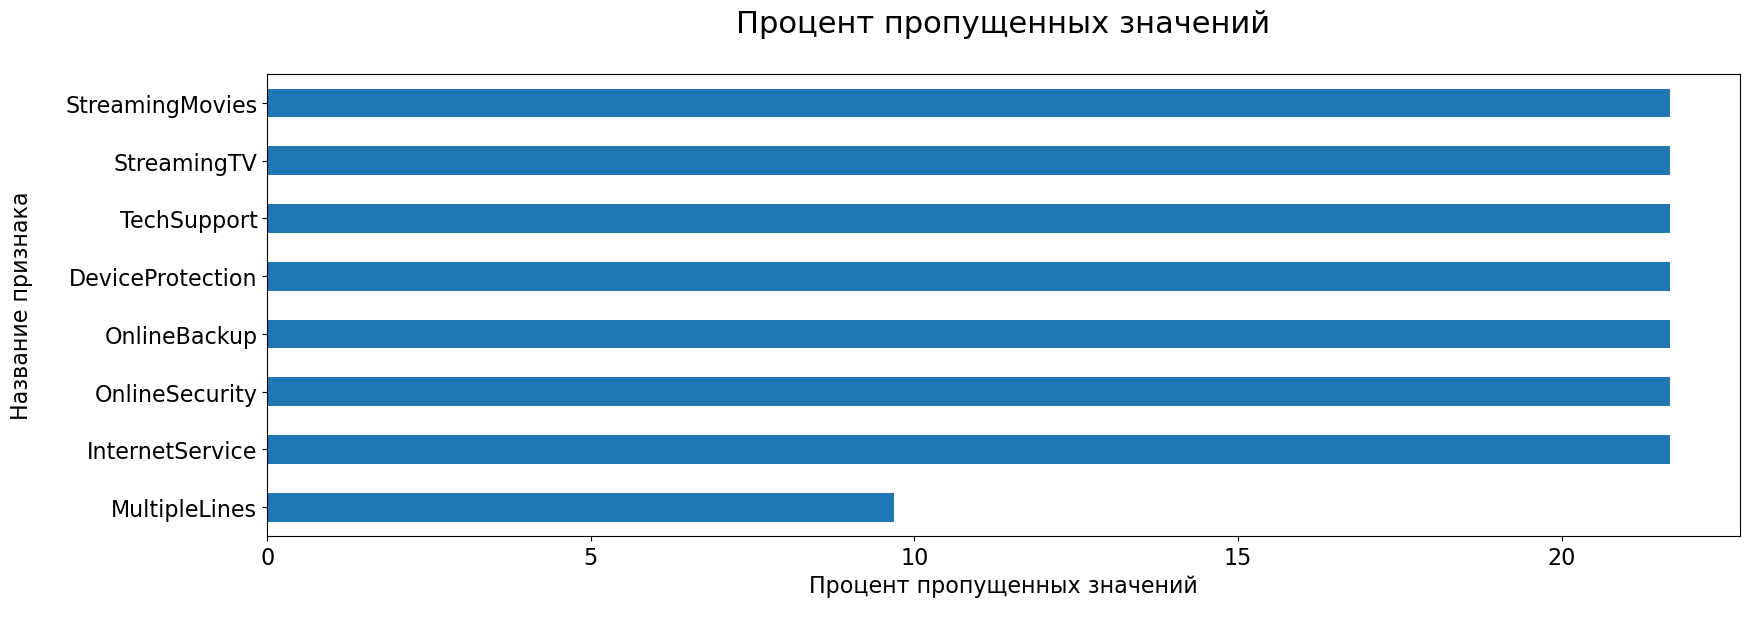

In [100]:
pass_value_barh(total_data)

После объединения в общий датафрейм появились пропуски в признаках подключенных услуг и подключенных линий. Т.к. у нас нет точной информации по этим данным выполним заполнение пропусков заглушкой вида '-1'. Заглушка выполнена в виде строки т.к. столбцы имеют тип object.

In [102]:
object_columns = list(filter(lambda col: total_data[col].dtype == 'object', total_data.columns.tolist()))
        
for column in total_data[object_columns]:
    total_data[column].fillna('-1', inplace=True)
#     total_data[column].fillna('No', inplace=True)
    print ('Passes in', column, 'filled')

Passes in gender filled
Passes in SeniorCitizen filled
Passes in Partner filled
Passes in Dependents filled
Passes in Type filled
Passes in PaperlessBilling filled
Passes in PaymentMethod filled
Passes in InternetService filled
Passes in OnlineSecurity filled
Passes in OnlineBackup filled
Passes in DeviceProtection filled
Passes in TechSupport filled
Passes in StreamingTV filled
Passes in StreamingMovies filled
Passes in MultipleLines filled


In [103]:
total_data.InternetService.unique()

array(['DSL', 'Fiber optic', '-1'], dtype=object)

In [104]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   active            7043 non-null   int64  
 10  duration          7043 non-null   int64  
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [105]:
# val_list = total_data.drop(['TotalCharges','MonthlyCharges','duration'], axis=1).columns.tolist()
val_list = list(total_data.dtypes[total_data.dtypes=='object'].index)
val_count(total_data, val_list)

Количество значений gender
Male      3555
Female    3488
Name: count, dtype: int64

Количество значений SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

Количество значений Partner
No     3641
Yes    3402
Name: count, dtype: int64

Количество значений Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Количество значений Type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

Количество значений PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

Количество значений PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

Количество значений InternetService
Fiber optic    3096
DSL            2421
-1             1526
Name: count, dtype: int64

Количество значений OnlineSecurity
No     3498
Yes    2019
-1     1526
Name: count, dtype: int64

Количество значений OnlineBackup
No     308

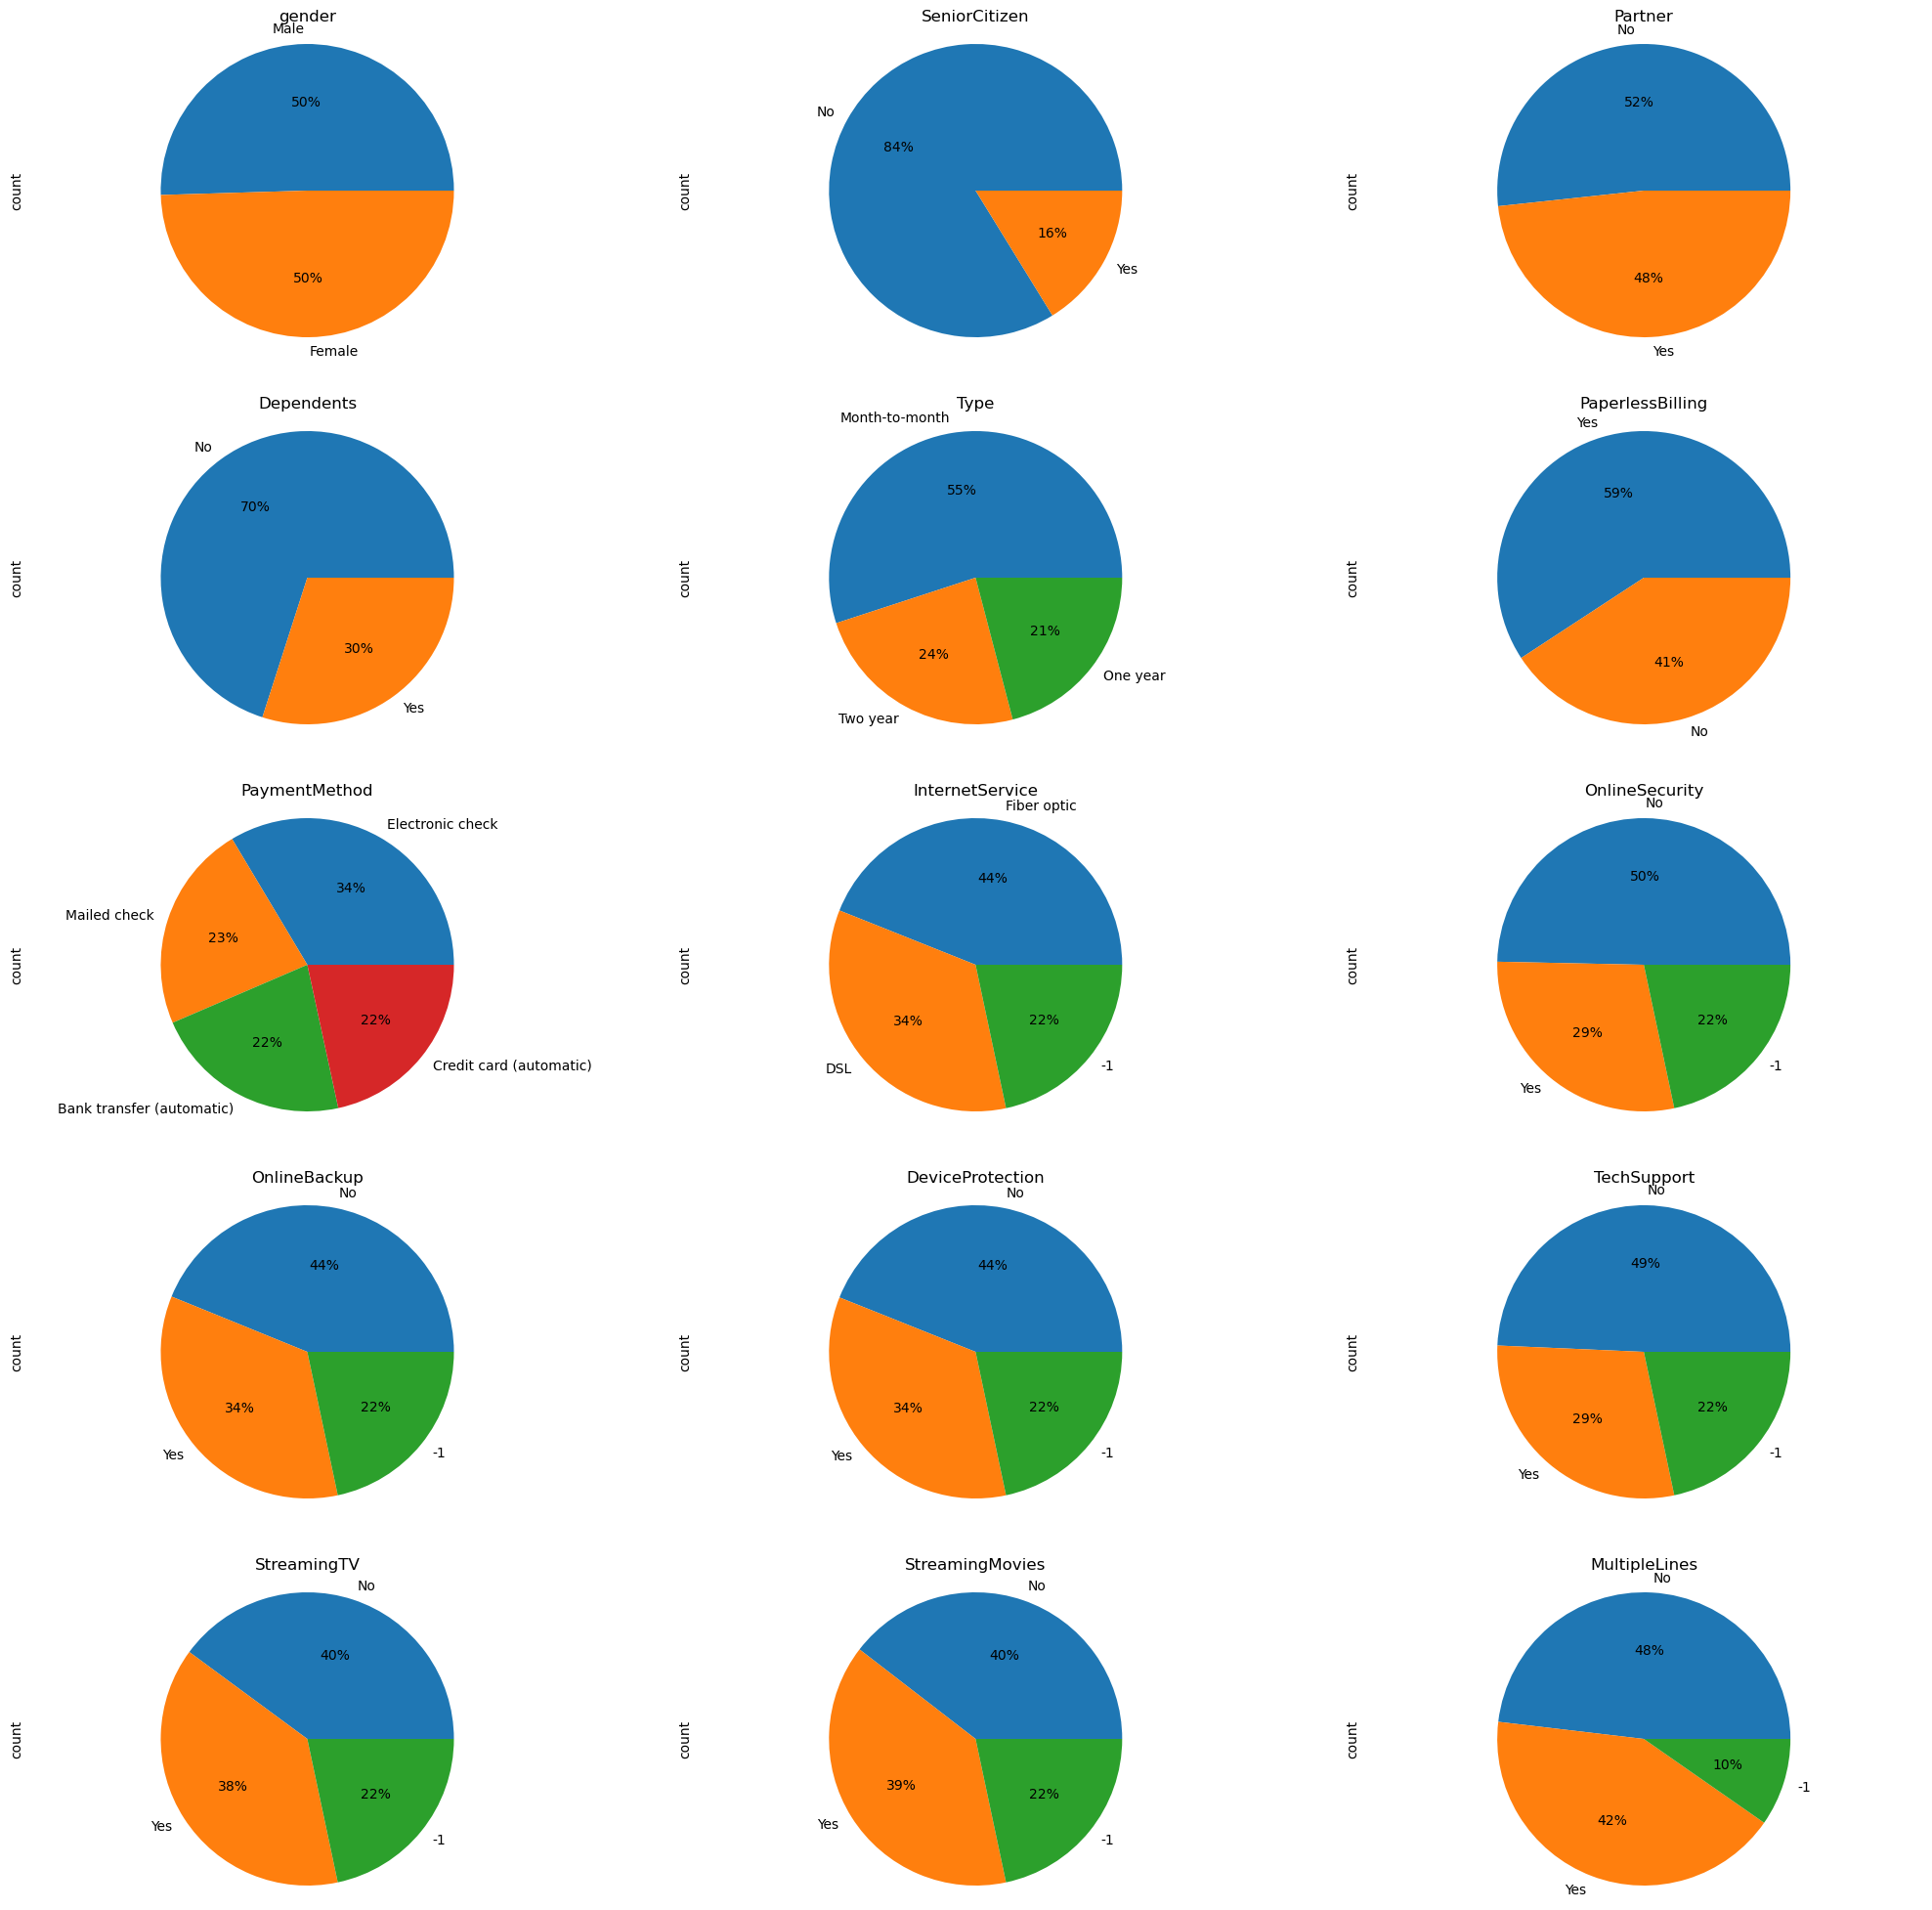

In [106]:
fig = create_pie_chart_matrix(total_data, val_list, 3, 6, size=(25, 30))
# create_pie_chart_matrix(total_data, val_list, 3, 6, size=(25, 30))
# plt.show()

In [107]:
def hist_categorical(data, col, rotate=45):
    sns.histplot(
        data,
        x=col,
        hue='active',
        multiple='fill'
    )

    plt.title(f'Отток клиентов по признаку "{col}"')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(rotation=rotate)
    plt.ylabel('Доля')

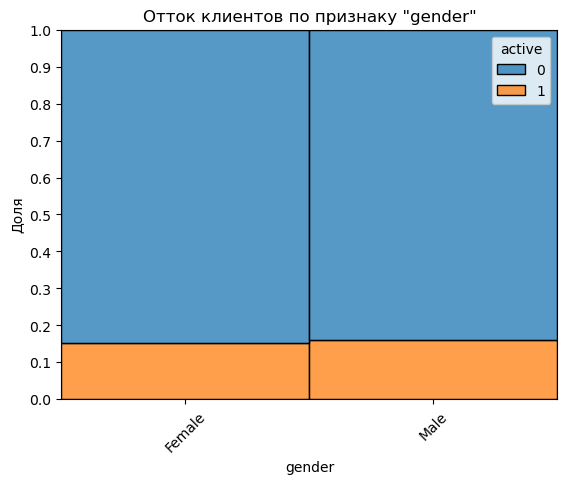

In [108]:
hist_categorical(total_data, 'gender')

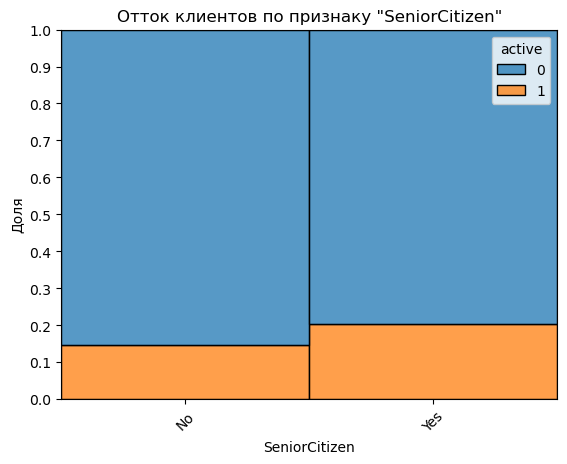

In [109]:
hist_categorical(total_data, 'SeniorCitizen')

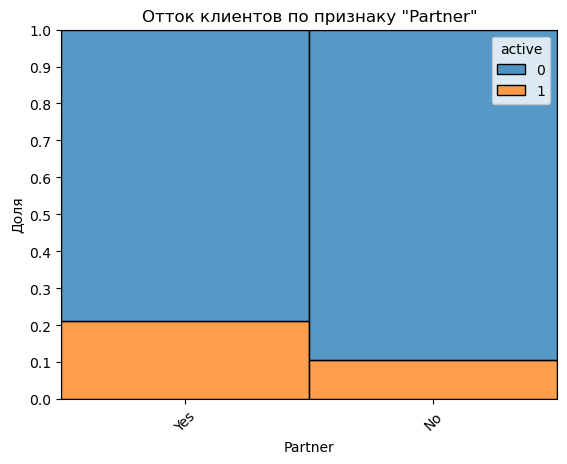

In [110]:
hist_categorical(total_data, 'Partner')

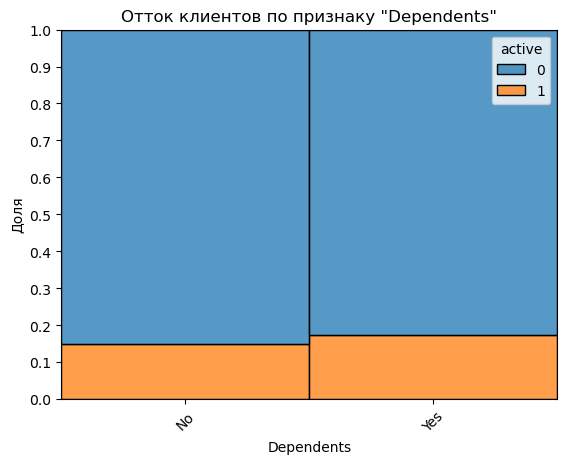

In [111]:
hist_categorical(total_data, 'Dependents')

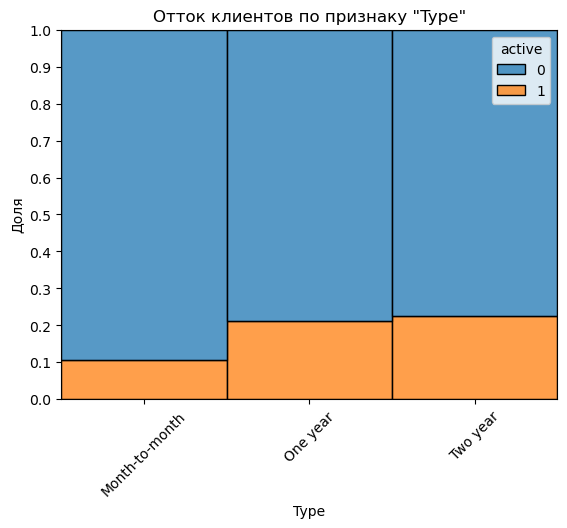

In [112]:
hist_categorical(total_data, 'Type')

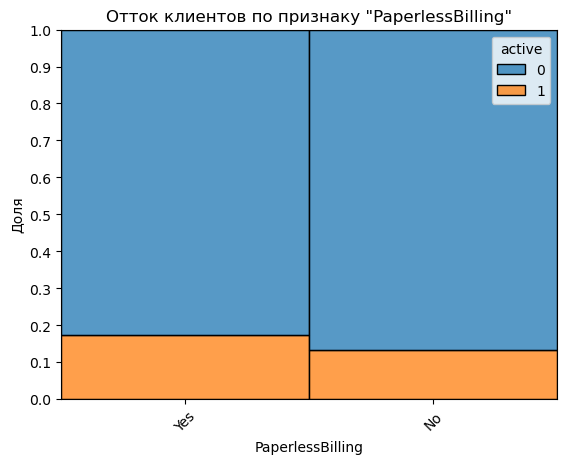

In [113]:
hist_categorical(total_data, 'PaperlessBilling')

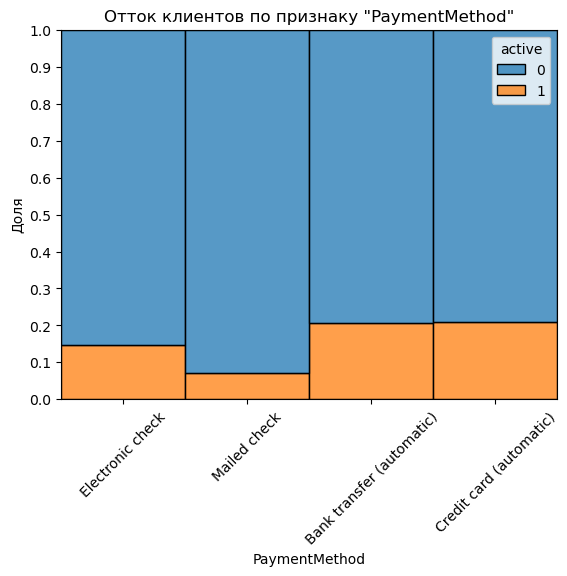

In [114]:
hist_categorical(total_data, 'PaymentMethod')

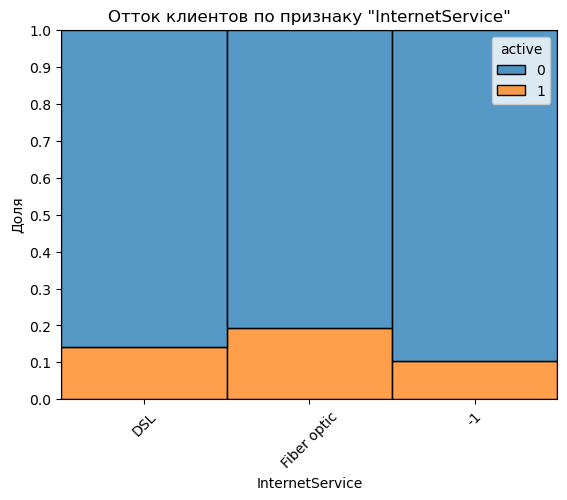

In [115]:
hist_categorical(total_data, 'InternetService')

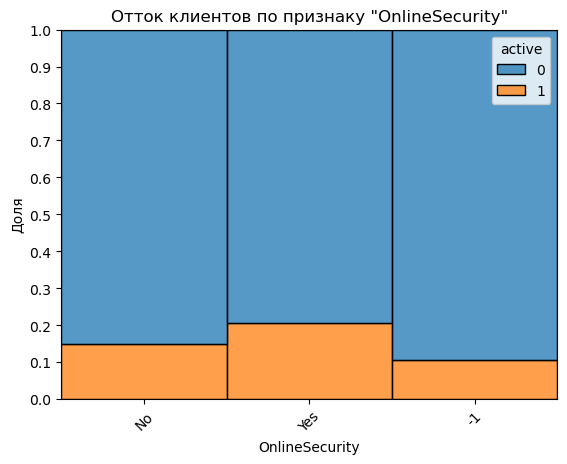

In [116]:
hist_categorical(total_data, 'OnlineSecurity')

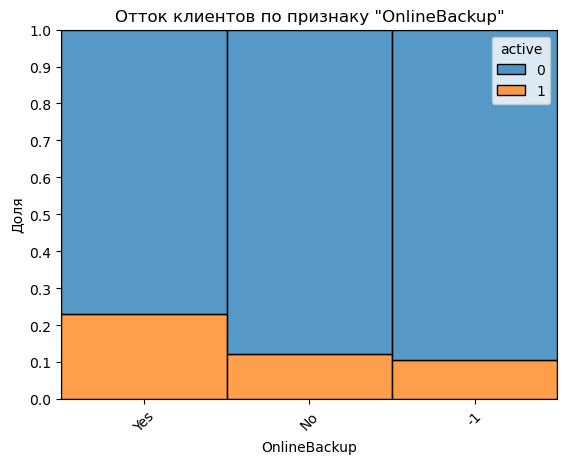

In [117]:
hist_categorical(total_data, 'OnlineBackup')

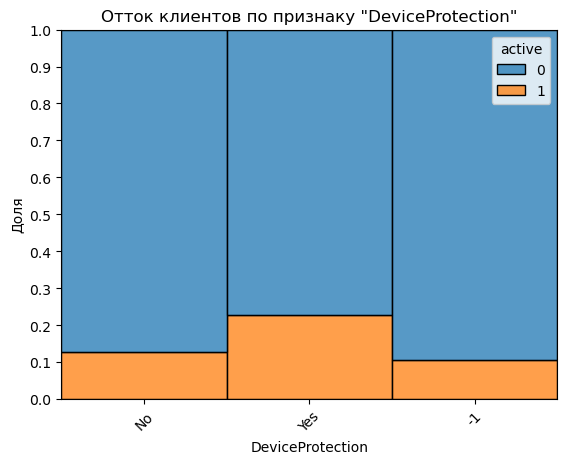

In [118]:
hist_categorical(total_data, 'DeviceProtection')

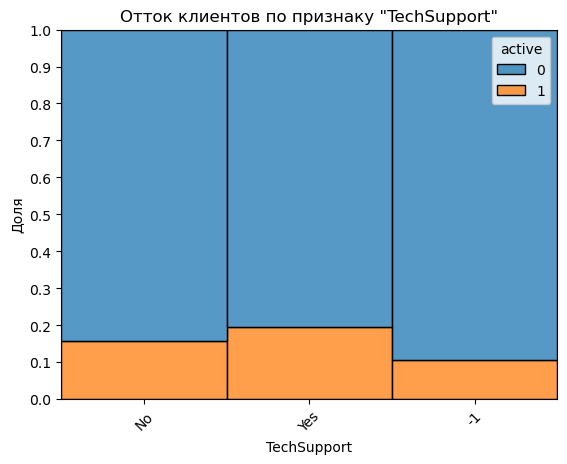

In [119]:
hist_categorical(total_data, 'TechSupport')

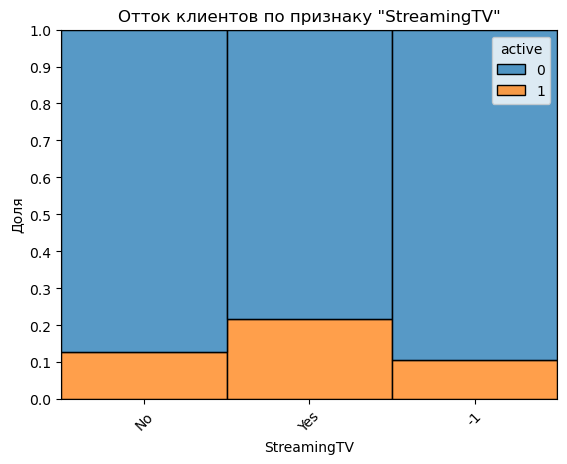

In [120]:
hist_categorical(total_data, 'StreamingTV')

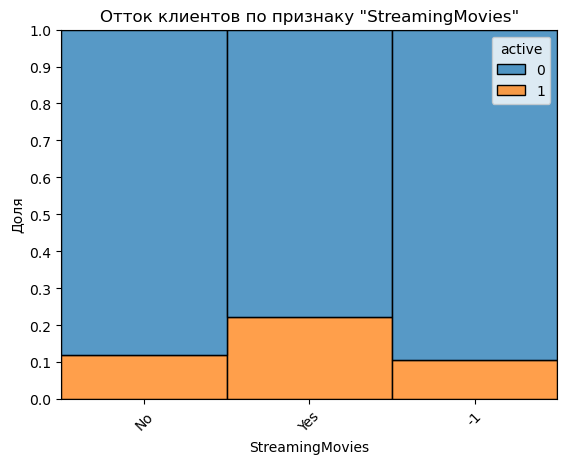

In [121]:
hist_categorical(total_data, 'StreamingMovies')

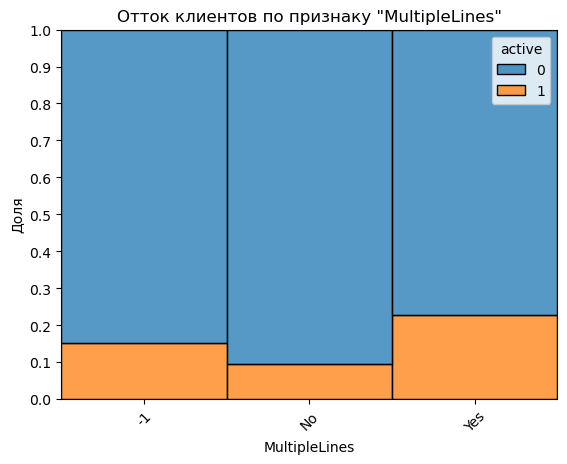

In [122]:
hist_categorical(total_data, 'MultipleLines')

### Промежуточный вывод
- По признакам gender/наличие детей/ примерно одинаковое распределение ушедших и оставшихся
- Клиенты пенсионеры/имеющие партнера/с электронным расчетным листом чаще отказываются от услуг
- Клиенты оплачивающие услуги ежемесячно/в электроной форме уходят реже
- по методу оплаты - клиенты со счетом приходящим на почту уходят реже
- по ежемесячным тратам больше клиентов  - чем выше оплата тем больше ушедших
- по типу подключения - клиенты подключенные по оптике уходят чаще
- по различным интернет услугам - чаще уходят клиенты с подключенными услугами

### Коррелляции

In [125]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   active            7043 non-null   int64  
 10  duration          7043 non-null   int64  
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

In [126]:
# interval_cols
interval_cols = list(filter(lambda col: total_data[col].dtype != 'object', total_data.columns.tolist()))
interval_cols

['MonthlyCharges', 'TotalCharges', 'active', 'duration']

In [127]:
interval_cols.remove('active')
interval_cols

['MonthlyCharges', 'TotalCharges', 'duration']

In [128]:
corr_matrix = total_data.phik_matrix(interval_cols=(interval_cols))
corr_matrix

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active,duration,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009025,0.000000,0.008581,0.000000,0.000000,0.001460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.304691,0.135650,0.086159,0.063315,0.160702,0.127319,0.109995,0.110177,0.135283,0.111714,0.113778,0.087925
Partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.203237,0.381958,0.226688,0.453688,0.000000,0.091202,0.092012,0.100092,0.076326,0.082251,0.077506,0.086249
Dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.184213,0.084247,0.046871,0.198729,0.108463,0.117219,0.097766,0.094597,0.109753,0.088193,0.084684,0.011198
Type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.388266,0.470860,0.094015,0.634155,0.505187,0.636884,0.581660,0.631531,0.671629,0.549564,0.553556,0.244410
PaperlessBilling,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.467783,0.201703,0.083398,0.026799,0.231438,0.208320,0.195321,0.195687,0.200621,0.204717,0.202241,0.099953
PaymentMethod,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.399536,0.335666,0.214832,0.350964,0.323886,0.315799,0.293413,0.297923,0.317713,0.284531,0.285525,0.174849
MonthlyCharges,0.009025,0.304691,0.203237,0.184213,0.388266,0.467783,0.399536,1.000000,0.711035,0.225925,0.387579,0.918980,0.812633,0.818858,0.827318,0.816603,0.864642,0.863641,0.710101
TotalCharges,0.000000,0.135650,0.381958,0.084247,0.470860,0.201703,0.335666,0.711035,1.000000,0.302890,0.848337,0.490081,0.516538,0.550544,0.558393,0.527838,0.555322,0.554030,0.467787
active,0.008581,0.086159,0.226688,0.046871,0.094015,0.083398,0.214832,0.225925,0.302890,1.000000,0.374569,0.056621,0.058659,0.089704,0.085608,0.051537,0.078545,0.086577,0.105101


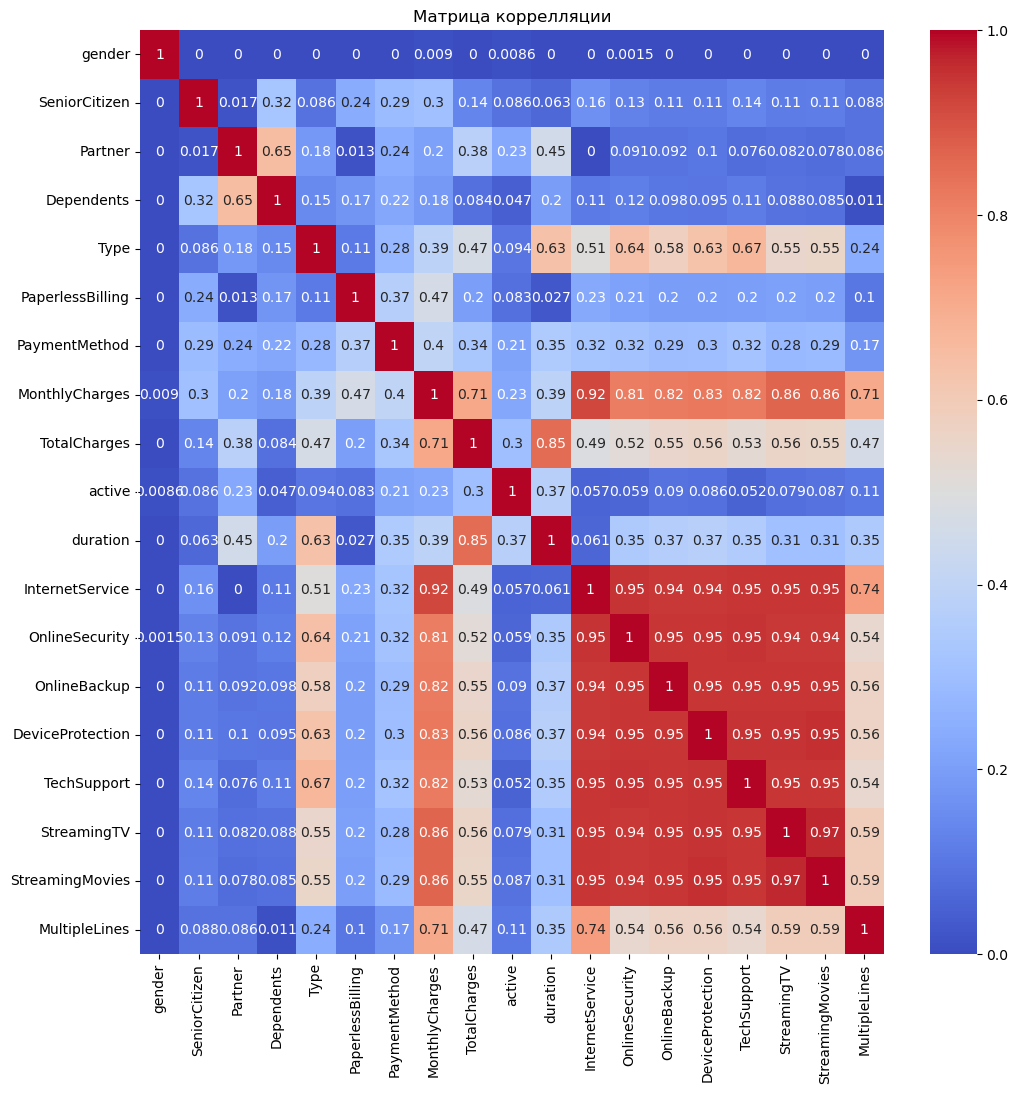

In [129]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции")
plt.show()

#### выводы по phik_matrix
    Исключим признак MonthlyCharges т.к. он имеет достаточно высокую корелляцию (мультиколлинеарность) с признаками по подключенным интернет услугам и сервисам


    Также между признаками по подулюченным услугам наблюдается мультиколлинеарность. Оставим только признак InternetService/
    Т.к. для всех вышеназванных признков коррелляция больше 0.91 сделаем список столбцов к удалению через функцию

In [131]:
# Коррелляции#функция для выбора из матрицы корреляции столбцов чья корреляция с заданным столбцом > num
def corr_func(num, df, column):
    n = num
    col = column
    cond = df[col]>n
    col_list = list(cond[cond].index)
    col_list.remove(col)
    print (list(col_list))
    print (df[col][col_list])
    return col_list

In [132]:
#столбцы с заданной коррелляцией
drop_list = corr_func (0.91, corr_matrix, 'InternetService')

['MonthlyCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
MonthlyCharges      0.918980
OnlineSecurity      0.949498
OnlineBackup        0.942842
DeviceProtection    0.942811
TechSupport         0.948914
StreamingTV         0.946713
StreamingMovies     0.946294
Name: InternetService, dtype: float64


In [133]:
# InternetService           
total_data = total_data.drop(drop_list, axis=1)
# total_data = total_data.drop('MonthlyCharges', axis=1)

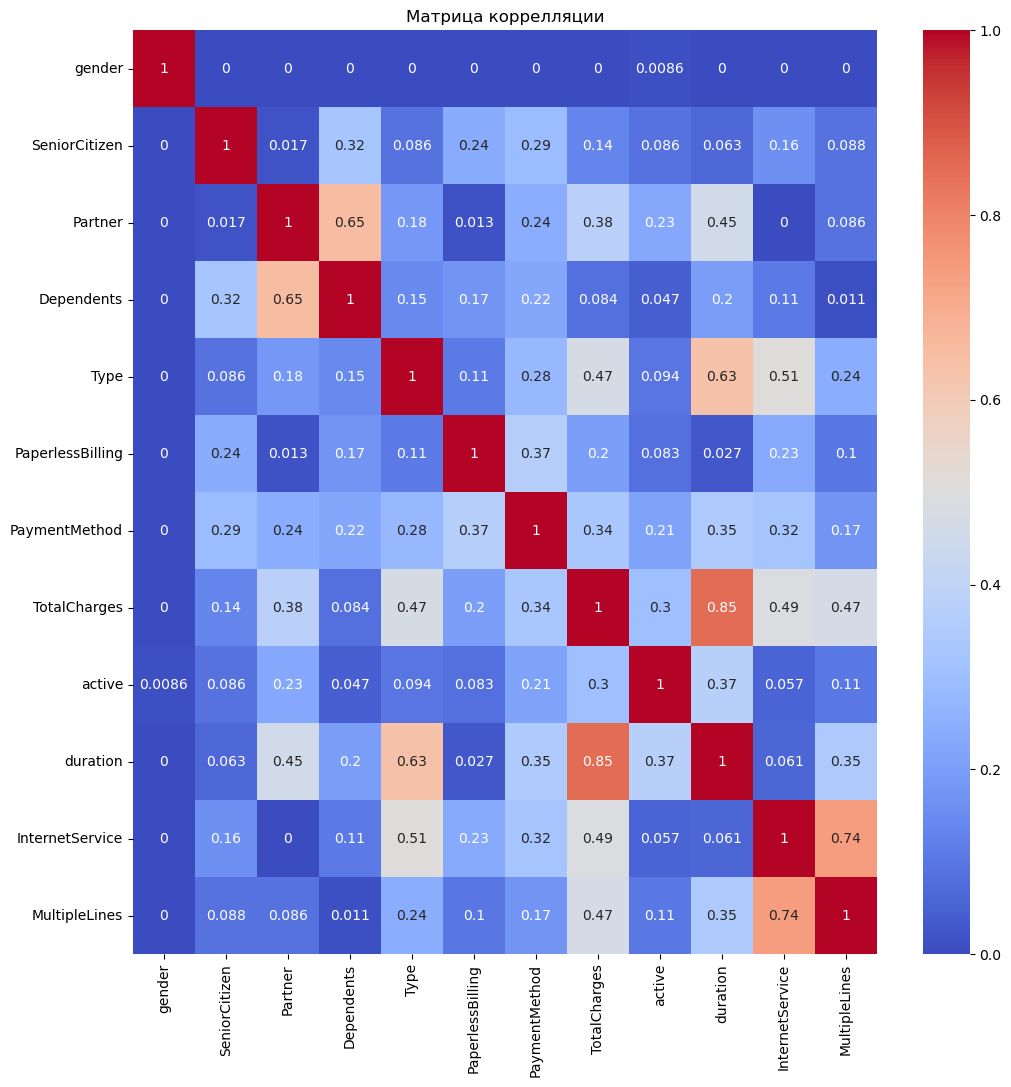

In [134]:
corr_matrix = total_data.phik_matrix(interval_cols=(interval_cols))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции")
plt.show()

In [135]:
#столбцы с заданной коррелляцией
col_list = corr_func (0.01, corr_matrix, 'active')

['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'duration', 'InternetService', 'MultipleLines']
SeniorCitizen       0.086159
Partner             0.226688
Dependents          0.046871
Type                0.094015
PaperlessBilling    0.083398
PaymentMethod       0.214832
TotalCharges        0.302890
duration            0.374569
InternetService     0.056621
MultipleLines       0.105101
Name: active, dtype: float64


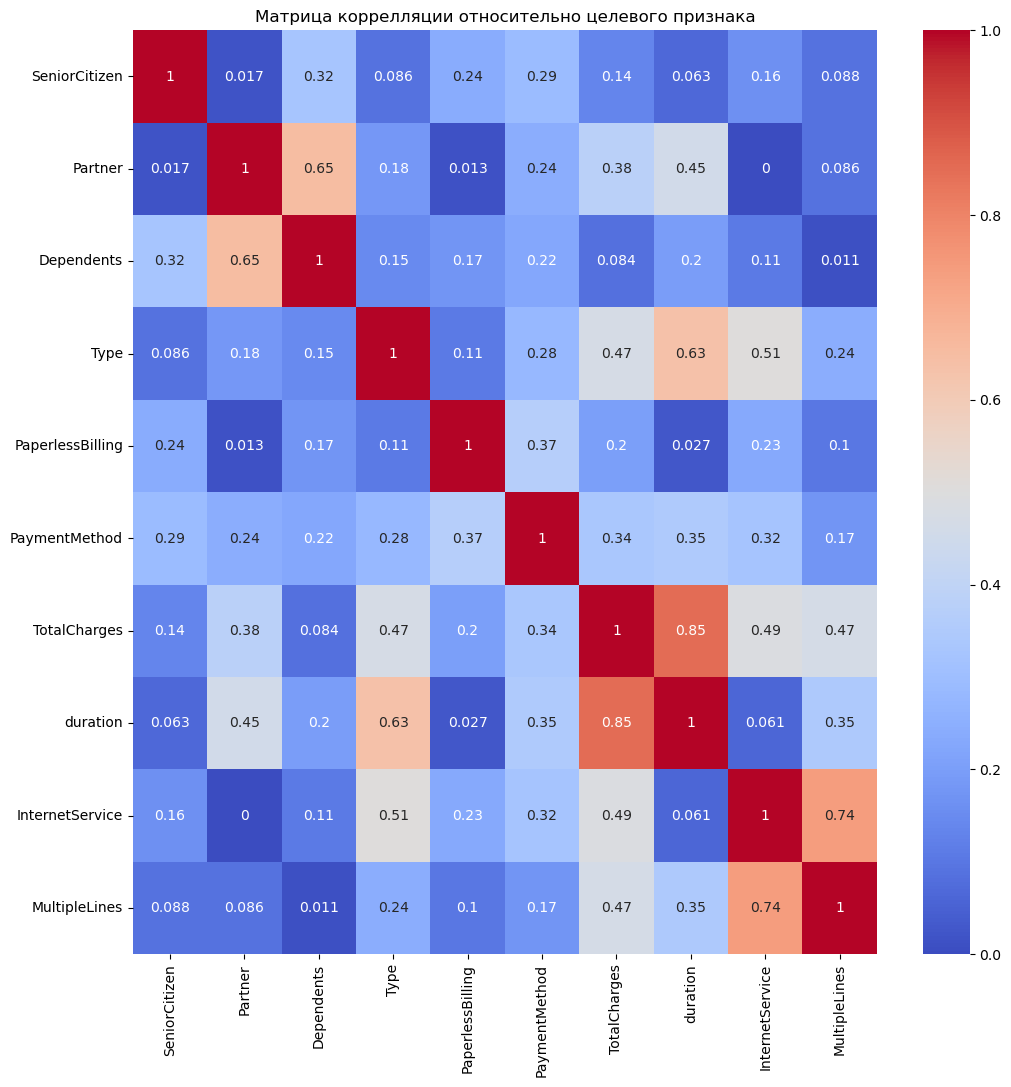

In [136]:
corr_matrix2 = total_data[(col_list)].phik_matrix(interval_cols=(interval_cols))
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Матрица коррелляции относительно целевого признака")
plt.show()

#### Вывод
- У целевого признака не наблюдается критических показателей корелляции с остальными
- Наибольшая корелляция между показателем общих затрат клиента и продолжительнльностью действия договора (вполне логично)
- Также большие корелляции наблюдаются между признаками связанными с интернет услугами и общими затратами клиента 

### Вывод по разделу
- Пропуски в столбцах типа object заполнены значением '-1' в формате int
- Построены гистограммы оттока клиентов отосительно признаков
- По phik_matrix отобраны притзнаки для тренировки моделей

## Шаг 5. Подготовка данных
Выполните подготовку данных для обучения модели. Разделите данные на две выборки, при масштабировании и кодировании учитывайте особенности данных и моделей.

In [140]:
# выбор целевого признака
col = 'active'

# сохранение входных признаков в переменную X
X = total_data[col_list]

# сохранение целевого признака в переменную y
y = total_data[col]

In [141]:
X.head(5)

,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,TotalCharges,duration,InternetService,MultipleLines
customerID,,,,,,,,,,
7590-VHVEG,No,Yes,No,Month-to-month,Yes,Electronic check,31.04,31,DSL,-1
5575-GNVDE,No,No,No,One year,No,Mailed check,2071.84,1036,DSL,No
3668-QPYBK,No,No,No,Month-to-month,Yes,Mailed check,226.17,123,DSL,No
7795-CFOCW,No,No,No,One year,No,Bank transfer (automatic),1960.60,1371,DSL,-1
9237-HQITU,No,No,No,Month-to-month,Yes,Electronic check,353.50,153,Fiber optic,No


In [142]:
cat_col, num_col = split_col(X)
cat_col

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'MultipleLines']

In [143]:
num_col

['TotalCharges', 'duration']

In [144]:
features = X.copy()
target = y.copy()
features_categorical = features[cat_col]

In [145]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
#     shuffle=False,
    test_size=TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y)

In [146]:
print('features_train.shape', features_train.shape)
print('features_test.shape', features_test.shape)
print('target_train.shape', target_train.shape)
print('target_test.shape', target_test.shape)

# проверка соответствия столбцов в выборках
features_train.columns == features_test.columns

features_train.shape (5282, 10)
features_test.shape (1761, 10)
target_train.shape (5282,)
target_test.shape (1761,)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [147]:
cat_col, num_col = split_col(features_train)
cat_col

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'MultipleLines']

In [148]:
num_col

['TotalCharges', 'duration']

In [149]:
# Список признаков для OneHotEncoder в линейных моделях
ohe_cols_lin = ['SeniorCitizen', 'Partner', 'Dependents', 
                'Type', 'PaperlessBilling', 'PaymentMethod', 
                'InternetService', 'MultipleLines']

# # Список признаков для OneHotEncoder в моделях типа DecisionTreeClassifier и RandomForestClassifier
# ohe_cols_wood = ['gender', 'SeniorCitizen', 'Partner', 
#                  'Dependents', 'PaperlessBilling', 'MultipleLines']

# Список признаков OrdinalEncoder в моделях типа DecisionTreeClassifier и RandomForestClassifier
ord_cols_wood = ['SeniorCitizen', 'Partner', 'Dependents', 
                'Type', 'PaperlessBilling', 'PaymentMethod', 
                'InternetService', 'MultipleLines']

# Список признаков для StandardScaler в моделях
num_cols = ['TotalCharges', 'duration']

In [150]:
lin_preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_cols_lin),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

In [151]:
wood_preprocessor = ColumnTransformer([
#     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'), ohe_cols_wood),
    ('ord', OrdinalEncoder(), ord_cols_wood),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

## Шаг 6. Обучение моделей машинного обучения
Обучите как минимум две модели. Хотя бы для одной из них подберите как минимум два гиперпараметра.

In [153]:
# датафрейм для сохранения и сравнения результатов работы моделей
results_df = pd.DataFrame(columns=['Model', 'Best metric', 'Best params'])

### Logistic Regression

In [155]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_log_reg = Pipeline([
    ('preprocessor', lin_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

log_reg_grid = [  
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },
    
    
]
    

randomized_search = RandomizedSearchCV(
    pipe_log_reg, 
    log_reg_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(features_train, target_train)

LogReg_best_metric = round(randomized_search.best_score_, 3)
LogReg_best_params = randomized_search.best_params_
LogReg_best_model = randomized_search.best_estimator_


In [156]:
results_df.loc[0] = ['LogisticRegression', LogReg_best_metric, LogReg_best_params]
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
0,LogisticRegression,0.738,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(random_state=12082024)}"


In [157]:
LogReg_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'MultipleLines']),
                                                 ('num', StandardScaler(),
                                                  ['TotalCharges',
                                                   'duration'])])),
                ('models', LogisticRegression(random_state=12082024))])

### DecisionTreeClassifier

In [159]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_DTC = Pipeline([
    ('preprocessor', wood_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

DTC_grid = [  
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 6),
        'models__max_features': range (2, 6),
        'preprocessor__num': [StandardScaler()]  
            
    }
]
    

randomized_search = RandomizedSearchCV(
    pipe_DTC, 
    DTC_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(features_train, target_train)

DTC_best_metric = round(randomized_search.best_score_, 3)
DTC_best_params = randomized_search.best_params_
DTC_best_model = randomized_search.best_estimator_

In [160]:
results_df.loc[1] = ['DecisionTreeClassifier', DTC_best_metric, DTC_best_params]
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
1,DecisionTreeClassifier,0.779,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=12082024)}"
0,LogisticRegression,0.738,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(random_state=12082024)}"


### RandomForestClassifier

In [162]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_RFC = Pipeline([
    ('preprocessor', wood_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

RFC_grid = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators' : [10, 20, 50, 100, 150],
        'preprocessor__num': [StandardScaler()]            
    }
]
    

randomized_search = RandomizedSearchCV(
    pipe_RFC, 
    RFC_grid, 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(features_train, target_train)

RFC_best_metric = round(randomized_search.best_score_, 3)
RFC_best_params = randomized_search.best_params_
RFC_best_model = randomized_search.best_estimator_

In [163]:
results_df.loc[2] = ['RandomForestClassifier', RFC_best_metric, RFC_best_params]
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
2,RandomForestClassifier,0.807,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 150, 'models': RandomForestClassifier(random_state=12082024)}"
1,DecisionTreeClassifier,0.779,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=12082024)}"
0,LogisticRegression,0.738,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(random_state=12082024)}"


### LightGBM

In [165]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_LGBM = Pipeline([
    ('preprocessor', wood_preprocessor),
    ('models', LGBMClassifier(random_state=RANDOM_STATE))
])

LGBM_grid = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators' : [10, 20, 50, 100, 150], 
        'models__learning_rate': [0.01, 0.1, 1, 10],
        'models__max_depth': range(1, 11, 2)            
    }
]
    

randomized_search = RandomizedSearchCV(
    pipe_LGBM, 
    LGBM_grid, 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(features_train, target_train)

LGBM_best_metric = round(randomized_search.best_score_, 3)
LGBM_best_params = randomized_search.best_params_
LGBM_best_model = randomized_search.best_estimator_

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [166]:
results_df.loc[3] = ['LGBMClassifier', LGBM_best_metric, LGBM_best_params]
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
3,LGBMClassifier,0.859,"{'models__n_estimators': 50, 'models__max_depth': 3, 'models__learning_rate': 1, 'models': LGBMClassifier(random_state=12082024)}"
2,RandomForestClassifier,0.807,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 150, 'models': RandomForestClassifier(random_state=12082024)}"
1,DecisionTreeClassifier,0.779,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=12082024)}"
0,LogisticRegression,0.738,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(random_state=12082024)}"


### CatBoostClassifier (just interest)

In [168]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 1545-ACTAS to 6522-OIQSX
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     5282 non-null   object 
 1   Partner           5282 non-null   object 
 2   Dependents        5282 non-null   object 
 3   Type              5282 non-null   object 
 4   PaperlessBilling  5282 non-null   object 
 5   PaymentMethod     5282 non-null   object 
 6   TotalCharges      5282 non-null   float64
 7   duration          5282 non-null   int64  
 8   InternetService   5282 non-null   object 
 9   MultipleLines     5282 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 583.0+ KB


In [169]:
# cat_features = ['SeniorCitizen', 'Partner', 'Dependents',
#                 'Type', 'PaperlessBilling', 'PaymentMethod',
#                 'MonthlyChargesCategory', 'InternetService',
#                 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
#                 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

cat_features = ['SeniorCitizen', 'Partner', 'Dependents', 
                'Type', 'PaperlessBilling', 'PaymentMethod', 
                'InternetService', 'MultipleLines']

train_pool = Pool(features_train, target_train, cat_features=cat_features)
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='AUC:hints=skip_train~false',
                                    auto_class_weights='Balanced',
                                    verbose=False)
params = {"depth": [5,10], 'learning_rate': [0.1, 1, 0.01]}
grid_search_results = cat_for_search.grid_search(params, train_pool, cv=5, verbose=False,  plot=False)


print(grid_search_results['params'])



bestTest = 0.920881797
bestIteration = 630


bestTest = 0.8999745566
bestIteration = 593


bestTest = 0.8418980808
bestIteration = 999


bestTest = 0.8931266356
bestIteration = 800


bestTest = 0.8445950858
bestIteration = 330


bestTest = 0.8419925851
bestIteration = 998

Training on fold [0/5]

bestTest = 0.9053163326
bestIteration = 998

Training on fold [1/5]

bestTest = 0.8951331497
bestIteration = 997

Training on fold [2/5]

bestTest = 0.9085943611
bestIteration = 867

Training on fold [3/5]

bestTest = 0.9062646669
bestIteration = 741

Training on fold [4/5]

bestTest = 0.9172873516
bestIteration = 889

{'depth': 5, 'learning_rate': 0.1}


In [170]:
cat_best_metric = round(cat_for_search.best_score_['learn']['AUC'], 3)
cat_best_params = cat_for_search.get_all_params().items()
# cat_best_model = randomized_search.best_estimator_

In [171]:
cat_best_metric

0.998

In [172]:

catboost = CatBoostClassifier(cat_features=cat_col,
                              eval_metric='AUC',
                              random_state=RANDOM_STATE,
                              verbose=300)

catboost.fit(features_train,
             target_train,
             eval_set=(features_test, target_test),
             use_best_model=True)

# Получаем вероятности для ROC-AUC
y_pred_prob = catboost.predict_proba(features_test)[:, 1]

# Вычисляем ROC-AUC
roc_auc = roc_auc_score(target_test, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')

Learning rate set to 0.047801
0:	test: 0.7249113	best: 0.7249113 (0)	total: 23.7ms	remaining: 23.6s
300:	test: 0.8878453	best: 0.8878551 (299)	total: 6.85s	remaining: 15.9s
600:	test: 0.9295913	best: 0.9295913 (600)	total: 14.1s	remaining: 9.36s
900:	test: 0.9382002	best: 0.9384620 (889)	total: 21.4s	remaining: 2.35s
999:	test: 0.9401823	best: 0.9402875 (982)	total: 23.9s	remaining: 0us

bestTest = 0.9402875321
bestIteration = 982

Shrink model to first 983 iterations.
ROC-AUC: 0.9403


In [173]:
results_df.loc[4] = ['CatBoostClassifier', cat_best_metric, '-']
# ['Model', 'Best metric', 'Best params', 'Best estimator']
results_df.sort_values('Best metric', ascending=False)

,Model,Best metric,Best params
4,CatBoostClassifier,0.998,-
3,LGBMClassifier,0.859,"{'models__n_estimators': 50, 'models__max_depth': 3, 'models__learning_rate': 1, 'models': LGBMClassifier(random_state=12082024)}"
2,RandomForestClassifier,0.807,"{'preprocessor__num': StandardScaler(), 'models__n_estimators': 150, 'models': RandomForestClassifier(random_state=12082024)}"
1,DecisionTreeClassifier,0.779,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=12082024)}"
0,LogisticRegression,0.738,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression(random_state=12082024)}"


### Вывод по разделу
    Для решения задачи были выбранымодели:
    - LogisticRegression	
    - DecisionTreeClassifier	
    - RandomForestClassifier	
    - LGBMClassifier
    - CatBoostClassifier
    Все модели прошли обучение, результаты метрики на тренировочной выборке данных объединены в таблицу. Модель CatBoostClassifier показала метрику равную 1, что говорит о ее переобучении. По результатам обучения лучшей оказалась модель LGBMClassifier с метрикой 0.859 на кросс-валидации тренировочной выборки

## Шаг 7. Выбор лучшей модели
Выберите лучшую модель и проверьте её качество на тестовой выборке.

In [176]:
LGBM_best_model.fit(features_train, target_train)
target_pred = LGBM_best_model.predict(features_test)
probabilities = LGBM_best_model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, probabilities)
print(f'Метрика ROC-AUC лучшей модели на тестовых даных: {round(auc_roc,3)}')

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [177]:
def plot_roc_curve(target_test, target_pred):
    print('ROC-AUC score', round(roc_auc_score(target_test, target_pred),3))
    
    fpr, tpr, thresholds = roc_curve(target_test, target_pred)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

ROC-AUC score 0.907


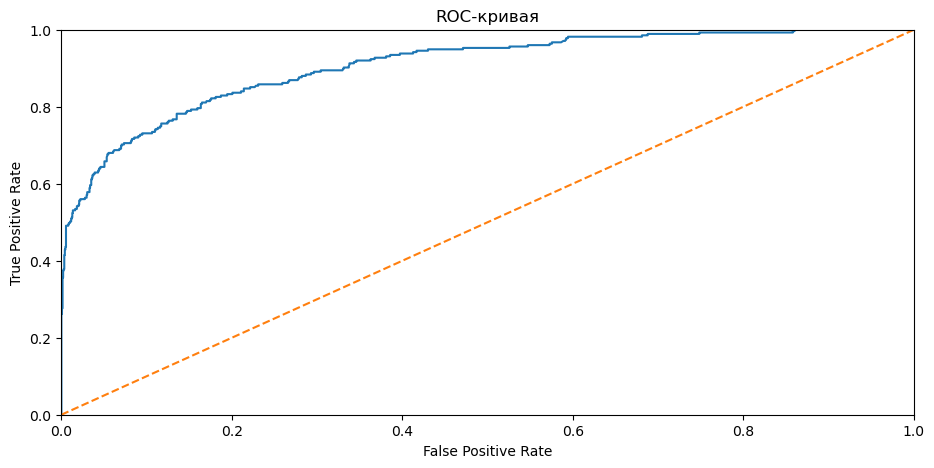

In [178]:
plot_roc_curve(target_test, probabilities)

In [179]:
# Анализ важности признаков
importances_df = pd.DataFrame(
    LGBM_best_model[-1].feature_importances_, 
    index=LGBM_best_model[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)
importances_df

,Важность признака
num__duration,179
num__TotalCharges,77
ord__PaymentMethod,16
ord__Type,15
ord__PaperlessBilling,9
ord__Partner,8
ord__MultipleLines,8
ord__InternetService,5
ord__SeniorCitizen,4
ord__Dependents,3


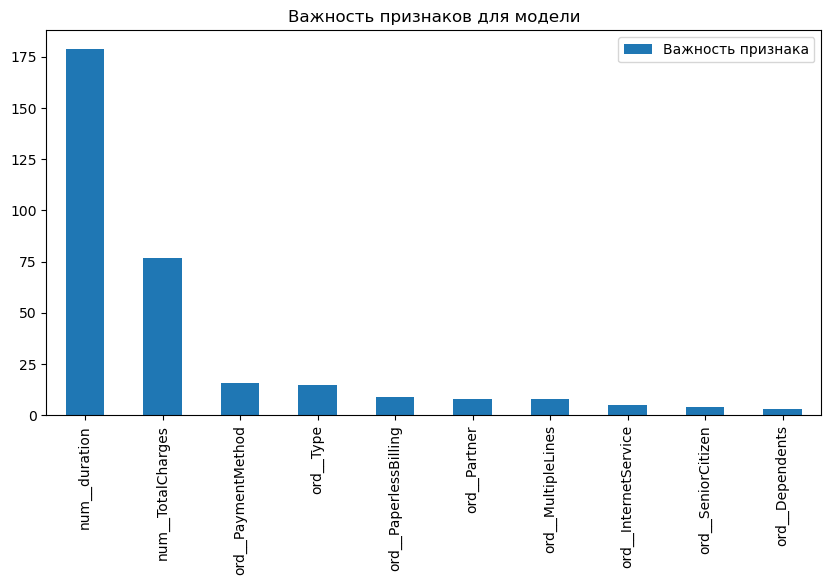

In [180]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность признаков для модели')
plt.show()

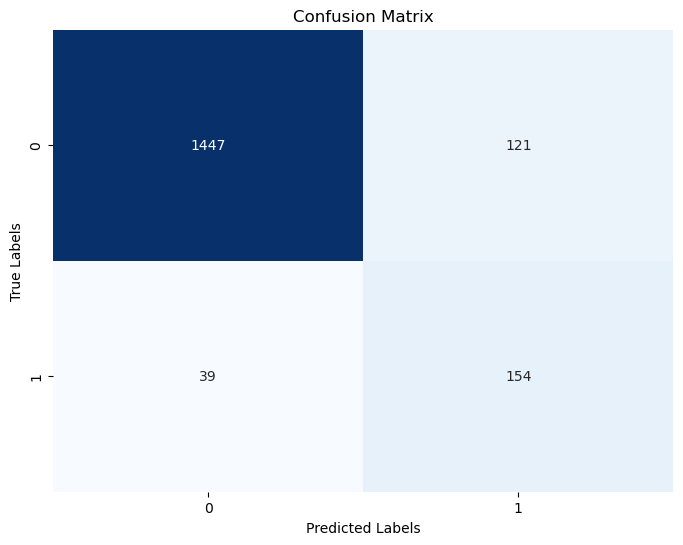

In [181]:
cm = confusion_matrix(target_pred, target_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [182]:
acc = accuracy_score(target_test, target_pred)
print('Метрика accuracy:', round(acc,3))

Метрика accuracy: 0.909


### Вывод по разделу
- Модель правильно определила 1447 ушедших клиента и 154 оставшихся
- Модель неправильно определила 39 ушедших клиента и 121 оставшихся
- Модель достаточно хорошо определяет классы с точностью в 91%
- Самыми важными для модели признаками оказались длительность договора и общие расходы абонента

## Шаг 8. Общий вывод и рекомендации заказчику
Сделайте общий вывод о проделанной работе: опишите основные этапы работы, полученные результаты и дайте рекомендации для бизнеса.

### Общий вывод
    В проекте проведена работа по предсказанию расторжения договора на оказываемые услуги между клиентом операторасвязи.
    Заказчиком предоставлены 4 датафрейма содержащие данные 
    - contract_new.csv — информация о договоре;
    - personal_new.csv — персональные данные клиента;
    - internet_new.csv — информация об интернет-услугах;
    - phone_new.csv — информация об услугах телефонии.

    
    Проведен исследовательский анализ и предварительная обработка данных. - Исходные данные не содержат явных дубликатов Обнаруженные пропуски заменены медианой. В исходных таблицах обнаружены признаки с неправильно определенным типом данных. 
    После объединения обнаружено что не для всех пользователей есть информация о подключенных услугах, пропуски в этих признаках заполнили '-1', в формате int.    
    Были добавлены 2 новых столбца:
    - целевой признак active, который означает активность клиента;
    - duration, который обозначает срок длительность действия договора в днях до его расторжения.
    Пропуски в столбцах типа object заполнены значением '-1' в формате int.
    Были проанализированы количественные и категоральные признаки, проведен анализ корелляций между признаками средствами библиотеки phik. По матрице наблюдается достаточно убедительная корелляция между длительностью договора и затратами клиентов.
    Были удалены признаки в которых наблюдалась мультиколлинеарность как с целевым признаком так и между собой.
    На этапе подготовеи данных было проведено разделение выборки на тренировочную и тестовую с выделением целевого признака в отдельные массивы. Разделение признаков проводилось в соотношении 3:1. Были созданы препроцессоры для построения простых линейных моделей (логистическая регрессия) и более тяжелых использующих бустинг или кросс-авлидацию.
    Для решения задачи были выбранымодели:
    - LogisticRegression    
    - DecisionTreeClassifier    
    - RandomForestClassifier    
    - LGBMClassifier
    - CatBoostClassifier
    Все модели прошли обучение, результаты метрики на тренировочной выборке данных объединены в таблицу. Модель CatBoostClassifier показала метрику равную 1, что говорит о ее переобучении. По результатам обучения лучшей оказалась модель LGBMClassifier с метрикой ROC-AUC 0.859 на тренировочной выборке. На тестовой выборке метрика составила 0.907
    Был проведен анализ важности признаков, наиболее значимыми для модели оказались признаки длительности договора и суммарных затрат клиента (что подтверждает предположения сделанные на этапе корелляций).
    Построенна матрица ошибок для модели. Точность модели составила 91%

### Рекомендации заказчику
- По признакам gender/наличие детей/ примерно одинаковое распределение ушедших и оставшихся - здесь можно предложить различные семейные тарифы, в т.ч. добавить пакетные предложения на мобильную связь если такого нет 
- Клиенты пенсионеры/имеющие партнера/с электронным расчетным листом чаще отказываются от услуг - относительно пенсионеров можно сделать 2 предположения - это одинокие люди и им не требуются услуги кроме простешей телефонии/телевидения или стоимость услуг у оператора слишком высока для них и можно предложить сделать пакеты услуг для пенсионеров, но для этого требуются отдельные исследования. Клиентам у которых есть партнер можно также предложить семейные пакеты услуг. 
- Клиенты оплачивающие услуги ежемесячно/в электроной форме уходят реже - можно рекомендовать переводить клиентов на помесячную оплату, т.к. небольшая сумма в счете за месяц спокойнее воспринимается клиентом чем многозначный счет за 1 или 2 года. Для этого можно сделать предложение по переходу на другой тариф с льготным периодом по сниженной ставке. Это сделает переход более мягким.
- по типу оплаты - клиенты со счетом приходящим на почту уходят реже. Больше всего уходит клиентов с автоматическим списанием оплаты с банковской карты.  Бумажные квитанции дополнить пуш/смс уведомлениями  или добавить выгрузку счета на оплату в кабинет на госуслугах или банковском приложении.
- по ежемесячным тратам больше клиентов  - чем выше оплата тем больше ушедших. Можно рекомендовать оператору пересмотреть и оптимизироватьсетку тарифов. Возможно в пакетах услуг достаточно услуг просто не нужных/неинтересных клиентам (опять про пенсионные/семейные/детские тарифы).
- по типу подключения - клиенты подключенные по оптике уходят чаще. Оператору следует обратить внимание на на качество предоставляемой услуги. Возмодно это частично связано с износом оборудования обеспечивающим стабльность сети и клиенты не получают желаемый результат.
- по различным интернет услугам - чаще уходят клиенты с подключенными услугами. Оператору следует обратить внимание на качество предоставляемых услуг. Т.к. больше клиентов уходит если услуги подключены. Наличие услуг может быть напрямую связано с размером абонентской платы.

    Итоговая рекомендация - по возможности провести исследование на определенных фокус-группах (молодые/семейные/пенсионеры/геймеры) чтобы создать пакетные предложения для разых категорий абонентов. В рамках текущего задания данные вопросы не рассматривались